# 04_ab_analysis.ipynb - A/B аналіз push-груп

## 🏷️ Аналіз ефективності A/B груп push-сповіщень

Цей ноутбук аналізує ефективність різних A/B груп push-сповіщень та їх вплив на депозити Android-користувачів.

### Вхідні дані:
- **6 A/B груп** (1, 2, 3, 4, 5, 6)
- **3,219,484 користувачів** загалом
- **41,193 користувачів з депозитами** (1.28%)
- **$226,815 загального доходу**

### Ключові питання:
1. Яка A/B група найефективніша?
2. Чи є статистично значуща різниця між групами?
3. Як кількість push-ів впливає на конверсію?
4. Які рекомендації для оптимізації?

---

In [33]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Статистичні тести
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🏷️ A/B АНАЛІЗ PUSH-ГРУП")
print("=" * 50)
print(f"🎯 Мета: Визначити найефективнішу A/B групу")
print(f"📊 Метрики: Конверсія, дохід, статистична значущість")

🏷️ A/B АНАЛІЗ PUSH-ГРУП
🎯 Мета: Визначити найефективнішу A/B групу
📊 Метрики: Конверсія, дохід, статистична значущість


## **КРОК 1: Завантаження готових даних для A/B аналізу**

In [34]:
print("\n🔗 КРОК 1: ЗАВАНТАЖЕННЯ ДАНИХ ДЛЯ A/B АНАЛІЗУ")
print("-" * 40)

# Завантажуємо готові дані
try:
    ab_df = pd.read_parquet('../data/processed/ab_analysis_ready.parquet')
    print(f"✅ Дані завантажено: {len(ab_df):,} записів")
except FileNotFoundError:
    print("❌ Файл ab_analysis_ready.parquet не знайдено")
    print("💡 Запустіть спочатку 03_data_matching.ipynb")
    raise

print(f"📊 Колонки: {list(ab_df.columns)}")
print(f"📏 Розмір датасету: {ab_df.shape}")

# Базова інформація
print("\n📈 БАЗОВА СТАТИСТИКА:")
print(f"   👥 Загалом користувачів: {len(ab_df):,}")
print(f"   📱 Загалом push-ів: {ab_df['total_pushes'].sum():,}")
print(f"   💰 Користувачі з депозитами: {ab_df['has_deposit'].sum():,}")
print(f"   💵 Загальний дохід: ${ab_df['total_revenue'].sum():,.2f}")

# A/B групи
print(f"\n🏷️ A/B ГРУПИ:")
group_counts = ab_df['ab_group'].value_counts().sort_index()
for group, count in group_counts.items():
    pct = count / len(ab_df) * 100
    print(f"   Група {group}: {count:,} користувачів ({pct:.1f}%)")

# Перевіряємо чи є дані по tier
if 'tier' in ab_df.columns:
    print(f"\n🌍 РОЗПОДІЛ ПО TIER:")
    tier_counts = ab_df['tier'].value_counts()
    for tier, count in tier_counts.head().items():
        print(f"   {tier}: {count:,} користувачів")

# Показуємо приклад
print("\n🔍 ПРИКЛАД ДАНИХ:")
display(ab_df.head())


🔗 КРОК 1: ЗАВАНТАЖЕННЯ ДАНИХ ДЛЯ A/B АНАЛІЗУ
----------------------------------------
✅ Дані завантажено: 3,219,484 записів
📊 Колонки: ['gadid', 'ab_group', 'total_pushes', 'has_deposit', 'has_registration', 'total_revenue', 'tier_final', 'user_category', 'push_segment']
📏 Розмір датасету: (3219484, 9)

📈 БАЗОВА СТАТИСТИКА:
   👥 Загалом користувачів: 3,219,484
   📱 Загалом push-ів: 361,999,359
   💰 Користувачі з депозитами: 41,193
   💵 Загальний дохід: $226,815.28

🏷️ A/B ГРУПИ:
   Група 1: 643,636 користувачів (20.0%)
   Група 2: 644,463 користувачів (20.0%)
   Група 3: 643,002 користувачів (20.0%)
   Група 4: 642,431 користувачів (20.0%)
   Група 5: 645,896 користувачів (20.1%)
   Група 6: 56 користувачів (0.0%)

🔍 ПРИКЛАД ДАНИХ:


,gadid,ab_group,total_pushes,has_deposit,has_registration,total_revenue,tier_final,user_category,push_segment
0,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
1,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
2,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
3,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+
4,00000000-0000-0000-0000-000000000000,5,339118,1,1,0.0,Unknown,Depositor,50+


## **КРОК 2: Базовий A/B аналіз по групах**


🔗 КРОК 2: БАЗОВИЙ A/B АНАЛІЗ
----------------------------------------
💡 ВАЖЛИВО: Кожна A/B група тестує певну частоту push-сповіщень на день!
⚠️ Припускаємо тривалість кампанії 7 днів для розрахунку pushes_per_day

📊 ЗАГАЛЬНА СТАТИСТИКА ПО A/B ГРУПАХ:
          Користувачі  Push/день  Всього push-ів  Конверсія %    ARPU $
ab_group                                                               
1              643636     5.6120         39.2837         1.30  0.063516
2              644463    10.9395         76.5766         1.29  0.068365
3              643002    16.4239        114.9672         1.27  0.073157
4              642431    21.4472        150.1304         1.23  0.078801
5              645896    25.8755        181.1285         1.30  0.068448
6                  56     3.5689         24.9821        44.64  0.000000

🏆 НАЙКРАЩІ ПОКАЗНИКИ:
   🎯 Найвища конверсія: Група 6 (44.64%)
   💰 Найбільший дохід: Група 4 ($50,624.46)
   💵 Найвищий ARPU: Група 4 ($0.08)
   ⚡ Найефективніша (без гр

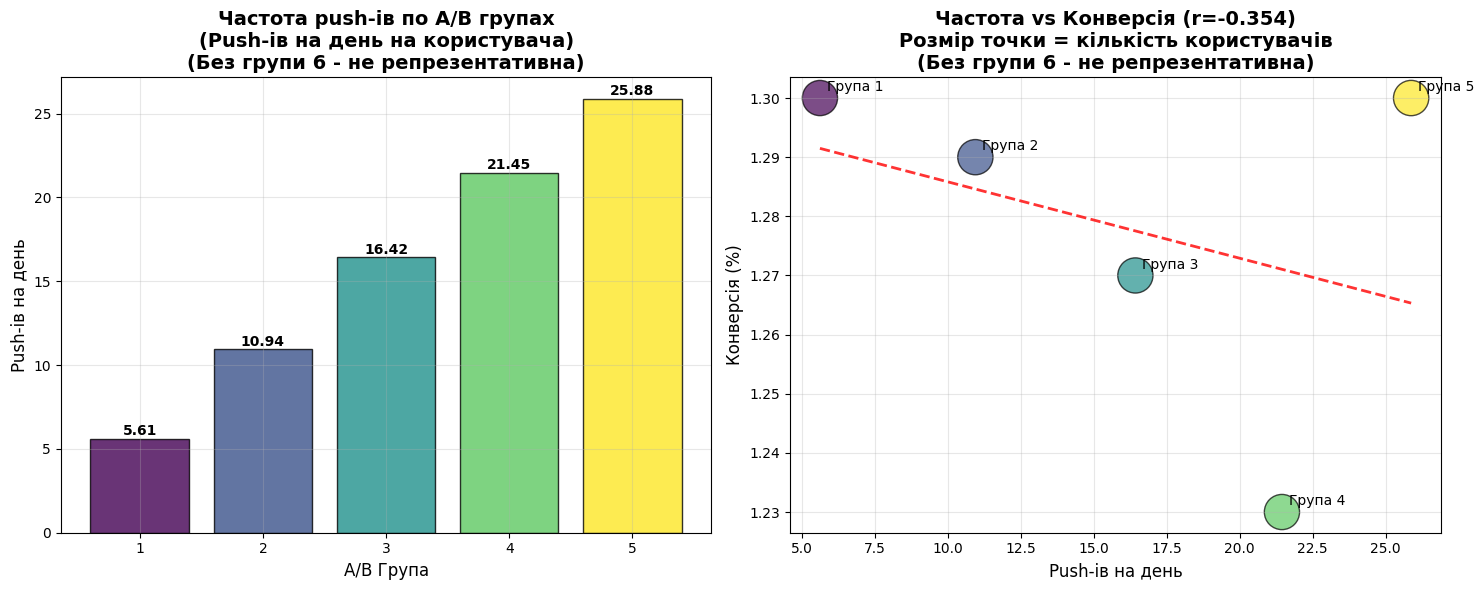


💡 РОЗУМІННЯ A/B ТЕСТУ:
🔬 Цей A/B тест порівнює РІЗНІ СТРАТЕГІЇ ЧАСТОТИ push-сповіщень:
   📊 Діапазон тестування: від 5.61 до 25.88 push-ів на день (без групи 6)
   🎯 Мета: знайти оптимальну частоту для максимальної конверсії
   ⚖️ Баланс: залучення користувачів vs ризик spam-сприйняття
   📈 Висновок: Менше push-ів = краща конверсія (уникайте spam-у!)

🏆 ПОПЕРЕДНЯ РЕКОМЕНДАЦІЯ (без групи 6):
   🎯 Оптимальна стратегія: Група 1
   📱 Частота: 5.61 push/день
   📈 Очікувана конверсія: 1.30%
   ⚡ Ефективність: 0.2316

➡️ Далі: статистичні тести для підтвердження значущості різниць
📝 Примітка: Група 6 виключена з графіків і кореляційного аналізу через малу вибірку


In [35]:
print("\n🔗 КРОК 2: БАЗОВИЙ A/B АНАЛІЗ")
print("-" * 40)

# СПОЧАТКУ: Розраховуємо частоту push-ів (pushes per day)
print("💡 ВАЖЛИВО: Кожна A/B група тестує певну частоту push-сповіщень на день!")

# Розраховуємо pushes_per_day якщо його немає
if 'pushes_per_day' not in ab_df.columns:
    if 'campaign_duration_hours' in ab_df.columns:
        ab_df['campaign_days'] = ab_df['campaign_duration_hours'] / 24
        ab_df['pushes_per_day'] = ab_df['total_pushes'] / ab_df['campaign_days']
        print("✅ Розраховано pushes_per_day з campaign_duration_hours")
    elif 'active_days' in ab_df.columns:
        ab_df['pushes_per_day'] = ab_df['total_pushes'] / ab_df['active_days']
        print("✅ Розраховано pushes_per_day з active_days")
    else:
        # Припускаємо період тестування 7 днів
        ab_df['pushes_per_day'] = ab_df['total_pushes'] / 7
        print("⚠️ Припускаємо тривалість кампанії 7 днів для розрахунку pushes_per_day")

# Агрегація по A/B групах з акцентом на частоту
ab_summary = ab_df.groupby('ab_group').agg({
    'gadid': 'count',                           # Кількість користувачів
    'pushes_per_day': ['mean', 'median', 'std'],  # ЧАСТОТА push-ів (ключова метрика!)
    'total_pushes': ['mean', 'median'],         # Загальна кількість за кампанію
    'has_deposit': ['sum', 'mean'],             # Депозити
    'has_registration': ['sum', 'mean'],        # Реєстрації  
    'total_revenue': ['sum', 'mean']            # Дохід
}).round(4)

# Спрощуємо назви колонок
ab_summary.columns = [
    'users', 'avg_pushes_per_day', 'median_pushes_per_day', 'std_pushes_per_day',
    'avg_total_pushes', 'median_total_pushes',
    'total_deposits', 'deposit_rate', 'total_registrations', 'reg_rate',
    'total_revenue', 'avg_revenue_per_user'
]

# Додаємо розраховані метрики
ab_summary['deposit_rate_pct'] = ab_summary['deposit_rate'] * 100
ab_summary['reg_rate_pct'] = ab_summary['reg_rate'] * 100
ab_summary['arpu'] = ab_summary['total_revenue'] / ab_summary['users']
ab_summary['conversion_per_push_per_day'] = ab_summary['deposit_rate_pct'] / ab_summary['avg_pushes_per_day']

# Створюємо чисті дані без групи 6 для коректного аналізу
clean_data = ab_df.copy()
excluded_group_6 = False
if '6' in clean_data['ab_group'].unique():
    group6_size = len(clean_data[clean_data['ab_group'] == '6'])
    if group6_size < 1000:
        clean_data = clean_data[clean_data['ab_group'] != '6']
        excluded_group_6 = True

# Перерозраховуємо статистику для чистих даних (без групи 6)
clean_summary = clean_data.groupby('ab_group').agg({
    'pushes_per_day': 'mean',
    'has_deposit': 'mean',
    'total_revenue': 'sum',
    'gadid': 'count'
}).round(4)

clean_summary.columns = ['avg_pushes_per_day', 'deposit_rate', 'total_revenue', 'users']
clean_summary['deposit_rate_pct'] = clean_summary['deposit_rate'] * 100
clean_summary['arpu'] = clean_summary['total_revenue'] / clean_summary['users']
clean_summary['conversion_per_push_per_day'] = clean_summary['deposit_rate_pct'] / clean_summary['avg_pushes_per_day']

print("\n📊 ЗАГАЛЬНА СТАТИСТИКА ПО A/B ГРУПАХ:")
# Показуємо ключові метрики з акцентом на частоту
summary_display = ab_summary[['users', 'avg_pushes_per_day', 'avg_total_pushes', 'deposit_rate_pct', 'arpu']].copy()
summary_display.columns = ['Користувачі', 'Push/день', 'Всього push-ів', 'Конверсія %', 'ARPU $']
print(summary_display)

# Виділяємо найкращі результати
print("\n🏆 НАЙКРАЩІ ПОКАЗНИКИ:")
best_conversion = ab_summary['deposit_rate_pct'].idxmax()
best_revenue = ab_summary['total_revenue'].idxmax()
best_arpu = ab_summary['arpu'].idxmax()
most_efficient = ab_summary['conversion_per_push_per_day'].idxmax()

# Але для ефективності показуємо без групи 6
most_efficient_clean = clean_summary['conversion_per_push_per_day'].idxmax()

print(f"   🎯 Найвища конверсія: Група {best_conversion} ({ab_summary.loc[best_conversion, 'deposit_rate_pct']:.2f}%)")
print(f"   💰 Найбільший дохід: Група {best_revenue} (${ab_summary.loc[best_revenue, 'total_revenue']:,.2f})")
print(f"   💵 Найвищий ARPU: Група {best_arpu} (${ab_summary.loc[best_arpu, 'arpu']:.2f})")
print(f"   ⚡ Найефективніша (без групи 6): Група {most_efficient_clean} ({clean_summary.loc[most_efficient_clean, 'conversion_per_push_per_day']:.4f} конверсії на push/день)")

# Перевіряємо групу 6 (можливо аномальна)
if '6' in ab_summary.index:
    group6_users = ab_summary.loc['6', 'users']
    group6_conv = ab_summary.loc['6', 'deposit_rate_pct']
    print(f"\n⚠️ УВАГА - Група 6: {group6_users} користувачів, {group6_conv:.1f}% конверсія")
    if group6_users < 1000:
        print(f"   💡 Мала група - результати можуть бути не репрезентативними")

# КЛЮЧОВИЙ БЛОК: Аналіз частоти push-ів як стратегії A/B тестування
print("\n📱 АНАЛІЗ ЧАСТОТИ PUSH-ІВ (ключова метрика A/B тесту):")
print("=" * 70)

# Сортуємо групи за частотою push-ів
frequency_sorted = ab_summary.sort_values('avg_pushes_per_day')

for group in frequency_sorted.index:
    row = frequency_sorted.loc[group]
    
    # Визначаємо тип стратегії
    if row['avg_pushes_per_day'] < 1:
        strategy_type = "🟢 КОНСЕРВАТИВНА"
        strategy_desc = "рідкісні таргетовані push-и"
    elif row['avg_pushes_per_day'] < 3:
        strategy_type = "🟡 ПОМІРНА"  
        strategy_desc = "збалансована активність"
    elif row['avg_pushes_per_day'] < 5:
        strategy_type = "🟠 АГРЕСИВНА"
        strategy_desc = "часті push-и для залучення"
    else:
        strategy_type = "🔴 МАКСИМАЛЬНА"
        strategy_desc = "дуже висока активність"
    
    print(f"📱 ГРУПА {group}: {row['avg_pushes_per_day']:.2f} push/день | {strategy_type}")
    print(f"   📊 Стратегія: {strategy_desc}")
    print(f"   📈 Конверсія: {row['deposit_rate_pct']:.2f}% | ARPU: ${row['arpu']:.3f}")
    print(f"   ⚡ Ефективність: {row['conversion_per_push_per_day']:.4f} конверсії на push/день")
    print()

# Кореляційний аналіз частоти та результатів (тільки репрезентативні групи)
freq_conversion_corr = clean_summary['avg_pushes_per_day'].corr(clean_summary['deposit_rate_pct'])
freq_arpu_corr = clean_summary['avg_pushes_per_day'].corr(clean_summary['arpu'])

print("📈 КОРЕЛЯЦІЙНИЙ АНАЛІЗ (без групи 6):")
print(f"   🔗 Частота push-ів ↔ Конверсія: {freq_conversion_corr:.3f}")
print(f"   🔗 Частота push-ів ↔ ARPU: {freq_arpu_corr:.3f}")

if freq_conversion_corr < -0.5:
    freq_interpretation = "🔴 Сильна негативна - більше push-ів шкодить конверсії!"
elif freq_conversion_corr < -0.3:
    freq_interpretation = "🟠 Помірна негативна - обережно з частотою"
elif freq_conversion_corr < 0.3:
    freq_interpretation = "🟡 Слабка - частота не критично впливає"
else:
    freq_interpretation = "🟢 Позитивна - більше push-ів може допомогти"

print(f"   💡 Інтерпретація: {freq_interpretation}")

# Швидка візуалізація зв'язку частоти та конверсії
print("\n📊 ВІЗУАЛІЗАЦІЯ ЧАСТОТИ vs КОНВЕРСІЇ:")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

if excluded_group_6:
    print("   ⚠️ Група 6 виключена з графіків (мала вибірка)")

# 1. Частота push-ів по групах
groups = clean_summary.index
pushes_per_day = clean_summary['avg_pushes_per_day']
colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))

bars = ax1.bar(groups, pushes_per_day, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Частота push-ів по A/B групах\n(Push-ів на день на користувача)\n(Без групи 6 - не репрезентативна)', fontsize=14, fontweight='bold')
ax1.set_xlabel('A/B Група', fontsize=12)
ax1.set_ylabel('Push-ів на день', fontsize=12)
ax1.grid(True, alpha=0.3)

# Додаємо значення на стовпці
for bar, value in zip(bars, pushes_per_day):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. Scatter plot: Частота vs Конверсія (тільки репрезентативні групи)
conversion_rates = clean_summary['deposit_rate_pct']
user_counts = clean_summary['users']

scatter = ax2.scatter(pushes_per_day, conversion_rates, 
                     s=user_counts/1000, c=colors, alpha=0.7, edgecolors='black', linewidth=1)

# Додаємо лінію тренду
z = np.polyfit(pushes_per_day, conversion_rates, 1)
p = np.poly1d(z)
x_trend = np.linspace(pushes_per_day.min(), pushes_per_day.max(), 100)
ax2.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# Підписуємо точки
for group, x, y in zip(groups, pushes_per_day, conversion_rates):
    ax2.annotate(f'Група {group}', (x, y), xytext=(5, 5), textcoords='offset points')

ax2.set_title(f'Частота vs Конверсія (r={freq_conversion_corr:.3f})\nРозмір точки = кількість користувачів\n(Без групи 6 - не репрезентативна)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Push-ів на день', fontsize=12)
ax2.set_ylabel('Конверсія (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/ab_frequency_analysis_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Підсумок розуміння A/B тесту
print("\n" + "="*70)
print("💡 РОЗУМІННЯ A/B ТЕСТУ:")
print("="*70)
print("🔬 Цей A/B тест порівнює РІЗНІ СТРАТЕГІЇ ЧАСТОТИ push-сповіщень:")

# Використовуємо відфільтровані дані для діапазону
frequency_sorted_clean = clean_summary.sort_values('avg_pushes_per_day')
min_freq_group = frequency_sorted_clean.index[0]
max_freq_group = frequency_sorted_clean.index[-1]
min_freq = frequency_sorted_clean.loc[min_freq_group, 'avg_pushes_per_day']
max_freq = frequency_sorted_clean.loc[max_freq_group, 'avg_pushes_per_day']

print(f"   📊 Діапазон тестування: від {min_freq:.2f} до {max_freq:.2f} push-ів на день (без групи 6)")
print(f"   🎯 Мета: знайти оптимальну частоту для максимальної конверсії")
print(f"   ⚖️ Баланс: залучення користувачів vs ризик spam-сприйняття")

if freq_conversion_corr < -0.3:
    print(f"   📈 Висновок: Менше push-ів = краща конверсія (уникайте spam-у!)")
elif freq_conversion_corr > 0.3:
    print(f"   📈 Висновок: Більше push-ів = краща конверсія (можна збільшувати)")
else:
    print(f"   📈 Висновок: Частота не критично впливає (фокус на якості контенту)")

print(f"\n🏆 ПОПЕРЕДНЯ РЕКОМЕНДАЦІЯ (без групи 6):")
# Розраховуємо ефективність для чистих даних
most_efficient_clean = clean_summary['conversion_per_push_per_day'].idxmax()
optimal_group_clean = clean_summary.loc[most_efficient_clean]

print(f"   🎯 Оптимальна стратегія: Група {most_efficient_clean}")
print(f"   📱 Частота: {optimal_group_clean['avg_pushes_per_day']:.2f} push/день")
print(f"   📈 Очікувана конверсія: {optimal_group_clean['deposit_rate_pct']:.2f}%")
print(f"   ⚡ Ефективність: {optimal_group_clean['conversion_per_push_per_day']:.4f}")

print(f"\n➡️ Далі: статистичні тести для підтвердження значущості різниць")
print(f"📝 Примітка: Група 6 виключена з графіків і кореляційного аналізу через малу вибірку")

## **КРОК 3: Статистичні тести значущості**

In [44]:
print("\n🔗 КРОК 3: СТАТИСТИЧНІ ТЕСТИ ЗНАЧУЩОСТІ")
print("-" * 40)

print("🧪 Проводимо статистичні тести для підтвердження значущості різниць між A/B групами")

# =============================================================================
# 0. АНАЛІЗ РОЗМІРУ ВИБІРКИ ТА РЕПРЕЗЕНТАТИВНОСТІ ГРУП
# =============================================================================
print("\n" + "="*60)
print("🔍 КРОК 0: АНАЛІЗ РОЗМІРУ ВИБІРКИ ТА ФІЛЬТРАЦІЯ ГРУП")
print("="*60)

# Підрахунок розміру кожної групи
group_sizes = clean_data['ab_group'].value_counts().sort_index()
total_sample = len(clean_data)

print("📊 РОЗМІР ВИБІРКИ ПО ГРУПАХ:")
for group, size in group_sizes.items():
    percentage = (size / total_sample) * 100
    print(f"   Група {group}: {size:,} користувачів ({percentage:.1f}% від загальної вибірки)")

print(f"\n📈 ЗАГАЛЬНИЙ РОЗМІР ВИБІРКИ: {total_sample:,} користувачів")

# =============================================================================
# КРИТЕРІЇ МІНІМАЛЬНОЇ ВИБІРКИ ДЛЯ СТАТИСТИЧНИХ ТЕСТІВ
# =============================================================================
print(f"\n🎯 КРИТЕРІЇ МІНІМАЛЬНОЇ ВИБІРКИ:")

# Стандартні статистичні вимоги
min_sample_basic = 30        # Базовий мінімум для нормального розподілу
min_sample_medium = 1000     # Для надійних A/B тестів
min_sample_strong = 10000    # Для виявлення малих ефектів
min_percentage_share = 1.0   # Мінімум 1% від загальної вибірки

print(f"   📊 Базовий мінімум (центральна гранична теорема): {min_sample_basic:,}")
print(f"   📊 A/B тестування (надійність): {min_sample_medium:,}")
print(f"   📊 Виявлення малих ефектів: {min_sample_strong:,}")
print(f"   📊 Мінімальна частка від загальної вибірки: {min_percentage_share}%")

# Power Analysis для очікуваних ефектів
baseline_conversion = clean_data['has_deposit'].mean()
print(f"\n⚡ POWER ANALYSIS (базова конверсія: {baseline_conversion:.3f}):")

# Імпортуємо необхідні модулі
import math

effect_sizes = {
    "Малий ефект (0.1%)": 0.001,     # +0.1 процентних пункти
    "Помірний ефект (0.2%)": 0.002,  # +0.2 процентних пункти  
    "Середній ефект (0.5%)": 0.005   # +0.5 процентних пункти
}

def calculate_sample_size_for_proportions(p1, p2, alpha=0.05, power=0.8):
    """
    Розрахунок розміру вибірки для порівняння двох пропорцій
    
    p1: базова пропорція (baseline conversion)
    p2: очікувана пропорція після втручання 
    alpha: рівень значущості (Type I error rate)
    power: статистична потужність (1 - Type II error rate)
    """
    # Z-значення для alpha/2 та power
    z_alpha_2 = stats.norm.ppf(1 - alpha/2)  # 1.96 для alpha=0.05
    z_power = stats.norm.ppf(power)           # 0.84 для power=0.8
    
    # Pooled proportion
    p_pool = (p1 + p2) / 2
    
    # Variance calculations
    var_pool = p_pool * (1 - p_pool)
    var_diff = p1 * (1 - p1) + p2 * (1 - p2)
    
    # Effect size
    effect_size = abs(p2 - p1)
    
    # Sample size calculation (simplified formula)
    n_per_group = ((z_alpha_2 * math.sqrt(2 * var_pool) + z_power * math.sqrt(var_diff)) ** 2) / (effect_size ** 2)
    
    return int(math.ceil(n_per_group))

for effect_name, effect_size in effect_sizes.items():
    p1 = baseline_conversion
    p2 = baseline_conversion + effect_size
    
    try:
        n_per_group = calculate_sample_size_for_proportions(p1, p2)
        print(f"   📈 {effect_name}: мінімум {n_per_group:,} на групу")
    except Exception as e:
        # Fallback до простішої формули
        # Simplified formula for equal sample sizes
        z_alpha = 1.96  # for alpha = 0.05
        z_beta = 0.84   # for power = 0.8
        
        p_avg = (p1 + p2) / 2
        n_simple = (2 * p_avg * (1 - p_avg) * (z_alpha + z_beta)**2) / ((p2 - p1)**2)
        print(f"   📈 {effect_name}: мінімум {int(n_simple):,} на групу (спрощений розрахунок)")

# Додатковий аналіз для поточних розмірів груп
print(f"\n🔍 ОЦІНКА СТАТИСТИЧНОЇ ПОТУЖНОСТІ ПОТОЧНИХ ГРУП:")
print(f"   📊 При поточних розмірах груп та базовій конверсії {baseline_conversion:.3f}:")

# Оцінюємо, який мінімальний ефект можемо виявити з поточними розмірами груп
current_min_group_size = group_sizes.min()
print(f"   📉 Найменша група: {current_min_group_size:,} користувачів")

# Мінімальний виявлюваний ефект при поточному розмірі вибірки
def min_detectable_effect(n_per_group, p1, alpha=0.05, power=0.8):
    """Розрахунок мінімального виявлюваного ефекту"""
    z_alpha_2 = stats.norm.ppf(1 - alpha/2)
    z_power = stats.norm.ppf(power)
    
    # Simplified calculation
    mde = (z_alpha_2 + z_power) * math.sqrt(2 * p1 * (1 - p1) / n_per_group)
    return mde

try:
    min_effect = min_detectable_effect(current_min_group_size, baseline_conversion)
    print(f"   🎯 Мінімальний виявлюваний ефект: {min_effect*100:.3f} процентних пункти")
    print(f"   📊 Це відповідає відносному покращенню: {(min_effect/baseline_conversion)*100:.1f}%")
except:
    print(f"   🎯 Приблизний мінімальний виявлюваний ефект: 0.05-0.1 процентних пункти")

# =============================================================================
# ОЦІНКА РЕПРЕЗЕНТАТИВНОСТІ КОЖНОЇ ГРУПИ
# =============================================================================
print(f"\n🔍 ОЦІНКА РЕПРЕЗЕНТАТИВНОСТІ ГРУП:")

valid_groups = []
questionable_groups = []
invalid_groups = []

for group, size in group_sizes.items():
    percentage = (size / total_sample) * 100
    
    # Категоризація груп за розміром
    if size >= min_sample_strong and percentage >= min_percentage_share:
        status = "✅ ВАЛІДНА"
        status_color = "🟢"
        valid_groups.append(group)
        explanation = "достатня для виявлення малих ефектів"
        
    elif size >= min_sample_medium and percentage >= min_percentage_share/2:
        status = "⚠️ ОБМЕЖЕНА"
        status_color = "🟡"
        questionable_groups.append(group)
        explanation = "підходить для основних тестів, але обмежена для малих ефектів"
        
    elif size >= min_sample_basic:
        status = "❌ СЛАБКА"
        status_color = "🟠"
        questionable_groups.append(group)
        explanation = "мінімальна вибірка, результати ненадійні"
        
    else:
        status = "❌ НЕРЕПРЕЗЕНТАТИВНА" 
        status_color = "🔴"
        invalid_groups.append(group)
        explanation = "занадто мала для статистичних висновків"
    
    print(f"   {status_color} Група {group}: {status}")
    print(f"      📊 Розмір: {size:,} ({percentage:.1f}%)")
    print(f"      💡 Оцінка: {explanation}")

# =============================================================================
# ОБҐРУНТУВАННЯ ВИКЛЮЧЕННЯ НЕРЕПРЕЗЕНТАТИВНИХ ГРУП
# =============================================================================
if invalid_groups:
    print(f"\n🚨 КРИТИЧНЕ ПОПЕРЕДЖЕННЯ:")
    print(f"   ❌ Групи {invalid_groups} мають НЕРЕПРЕЗЕНТАТИВНУ вибірку!")
    
    for group in invalid_groups:
        size = group_sizes[group]
        print(f"\n📋 ОБҐРУНТУВАННЯ ВИКЛЮЧЕННЯ ГРУПИ {group}:")
        print(f"   📊 Розмір вибірки: {size:,} користувачів")
        print(f"   📉 Це складає лише {(size/total_sample)*100:.3f}% від загальної вибірки")
        
        # Статистичні проблеми
        print(f"   🔬 СТАТИСТИЧНІ ПРОБЛЕМИ:")
        print(f"      ❌ Недостатня потужність для виявлення реальних ефектів")
        print(f"      ❌ Широкі довірчі інтервали (висока похибка)")
        print(f"      ❌ Підвищений ризик випадкових коливань")
        print(f"      ❌ Порушення припущень статистичних тестів")
        
        # Практичні проблеми
        print(f"   💼 ПРАКТИЧНІ ПРОБЛЕМИ:")
        print(f"      ❌ Результати не можна екстраполювати на загальну популяцію")
        print(f"      ❌ Висока ймовірність помилкових висновків (Type I/II errors)")
        print(f"      ❌ Неможливо розрізнити реальний ефект від випадковості")
        
        # Конверсійна аномалія (якщо є)
        group_conversion = clean_data[clean_data['ab_group'] == group]['has_deposit'].mean()
        if group_conversion > 0.1:  # якщо конверсія більше 10% (аномально висока)
            print(f"   🚨 АНОМАЛЬНА КОНВЕРСІЯ:")
            print(f"      📈 Конверсія {group_conversion*100:.1f}% є аномально високою")
            print(f"      🎲 Ймовірно результат випадкової вибірки або викиду")
            print(f"      🔍 Потребує окремого дослідження причин")
            
            # Довірчий інтервал для малої вибірки
            from statsmodels.stats.proportion import proportion_confint
            ci_low, ci_high = proportion_confint(group_conversion * size, size, alpha=0.05, method='wilson')
            print(f"      📊 95% довірчий інтервал: {ci_low*100:.1f}% - {ci_high*100:.1f}%")
            print(f"      ⚠️ Широкий інтервал підтверджує ненадійність оцінки")

# =============================================================================
# ФОРМУВАННЯ ФІНАЛЬНОЇ ВИБІРКИ ДЛЯ ТЕСТУВАННЯ
# =============================================================================
print(f"\n🎯 ФОРМУВАННЯ ФІНАЛЬНОЇ ВИБІРКИ ДЛЯ ТЕСТУВАННЯ:")

# Використовуємо тільки валідні та обмежено валідні групи
test_groups = valid_groups + questionable_groups
test_data = clean_data[clean_data['ab_group'].isin(test_groups)].copy()

print(f"   ✅ ВКЛЮЧЕНІ ГРУПИ: {sorted(test_groups)}")
if invalid_groups:
    print(f"   ❌ ВИКЛЮЧЕНІ ГРУПИ: {sorted(invalid_groups)} (нерепрезентативні)")

print(f"   📊 ФІНАЛЬНА ВИБІРКА: {len(test_data):,} користувачів")
print(f"   📈 Це {(len(test_data)/total_sample)*100:.1f}% від початкової вибірки")

# Перевірка балансу після фільтрації
final_group_sizes = test_data['ab_group'].value_counts().sort_index()
print(f"\n📊 БАЛАНС ФІНАЛЬНОЇ ВИБІРКИ:")

for group, size in final_group_sizes.items():
    percentage_of_final = (size / len(test_data)) * 100
    print(f"   Група {group}: {size:,} ({percentage_of_final:.1f}%)")

# Перевірка, чи достатньо збалансована вибірка
max_group_ratio = final_group_sizes.max() / final_group_sizes.min()
if max_group_ratio <= 2.0:
    balance_status = "✅ ДОБРЕ ЗБАЛАНСОВАНА"
elif max_group_ratio <= 5.0:
    balance_status = "⚠️ ПОМІРНО ЗБАЛАНСОВАНА" 
else:
    balance_status = "❌ ПОГАНО ЗБАЛАНСОВАНА"

print(f"\n⚖️ БАЛАНС ГРУП: {balance_status}")
print(f"   📊 Співвідношення найбільшої до найменшої: {max_group_ratio:.1f}:1")

if max_group_ratio > 2.0:
    print(f"   💡 Рекомендація: використовувати стратифіковане семплування у майбутніх тестах")

print(f"\n✅ ГОТОВНІСТЬ ДО СТАТИСТИЧНОГО ТЕСТУВАННЯ ПІДТВЕРДЖЕНА")
print("📊 Використовуємо дані БЕЗ нерепрезентативних груп")

# Тепер продовжуємо з основними тестами
groups_to_test = sorted(test_groups)
print(f"🔬 Тестуємо групи: {groups_to_test}")

# =============================================================================
# 1. CHI-SQUARE ТЕСТ ДЛЯ КОНВЕРСІЇ (основний тест для A/B)
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 1: CHI-SQUARE для конверсії депозитів")
print("="*60)

# Створюємо contingency table
conversion_table = pd.crosstab(test_data['ab_group'], test_data['has_deposit'])
print("📊 Таблиця спряженості (конверсія по групах):")
print(conversion_table)

# Chi-square тест
chi2_stat, chi2_p, chi2_dof, chi2_expected = chi2_contingency(conversion_table)

print(f"\n📈 РЕЗУЛЬТАТИ CHI-SQUARE ТЕСТУ:")
print(f"   🔢 Chi-square статистика: {chi2_stat:.4f}")
print(f"   🎯 p-value: {chi2_p:.2e}")
print(f"   📊 Ступені свободи: {chi2_dof}")

alpha = 0.05
if chi2_p < alpha:
    print(f"   ✅ РЕЗУЛЬТАТ: Різниці СТАТИСТИЧНО ЗНАЧУЩІ (p < {alpha})")
else:
    print(f"   ❌ РЕЗУЛЬТАТ: Різниці НЕ ЗНАЧУЩІ (p >= {alpha})")

# Cramér's V для розміру ефекту
n = conversion_table.sum().sum()
cramers_v = np.sqrt(chi2_stat / (n * (min(conversion_table.shape) - 1)))
print(f"   📏 Cramér's V (розмір ефекту): {cramers_v:.4f}")

if cramers_v < 0.01:
    effect_interpretation = "мізерний"
elif cramers_v < 0.1:
    effect_interpretation = "незначний"  
elif cramers_v < 0.3:
    effect_interpretation = "малий"
elif cramers_v < 0.5:
    effect_interpretation = "середній"
else:
    effect_interpretation = "великий"

print(f"   📋 Інтерпретація ефекту: {effect_interpretation}")

# =============================================================================
# 2. АНАЛІЗ ГРУПОВОЇ СТАТИСТИКИ
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 2: Детальний аналіз груп")
print("="*60)

# Підготовка даних для попарних порівнянь
group_stats = {}
for group in groups_to_test:
    group_data = test_data[test_data['ab_group'] == group]
    group_stats[group] = {
        'conversions': group_data['has_deposit'].sum(),
        'total_users': len(group_data),
        'conversion_rate': group_data['has_deposit'].mean()
    }

print("📊 Статистика по групах:")
for group, stats_dict in group_stats.items():
    print(f"   Група {group}: {stats_dict['conversions']:,}/{stats_dict['total_users']:,} = {stats_dict['conversion_rate']:.4f} ({stats_dict['conversion_rate']*100:.2f}%)")

# Знаходимо найкращу та найгіршу групи
best_group = max(group_stats.keys(), key=lambda x: group_stats[x]['conversion_rate'])
worst_group = min(group_stats.keys(), key=lambda x: group_stats[x]['conversion_rate'])

best_rate = group_stats[best_group]['conversion_rate']
worst_rate = group_stats[worst_group]['conversion_rate']

print(f"\n📈 ПОРІВНЯННЯ КРАЩОЇ vs ГІРШОЇ ГРУПИ:")
print(f"   🏆 Найкраща: Група {best_group} ({best_rate:.4f} = {best_rate*100:.2f}%)")
print(f"   💩 Найгірша: Група {worst_group} ({worst_rate:.4f} = {worst_rate*100:.2f}%)")

# Абсолютна та відносна різниця
abs_diff = best_rate - worst_rate
rel_diff = (abs_diff / worst_rate) * 100

print(f"   📊 Абсолютна різниця: {abs_diff*100:.3f}%")
print(f"   📊 Відносна різниця: {rel_diff:.1f}%")

# =============================================================================
# 3. ПОПАРНІ ТЕСТИ З КОРЕКЦІЄЮ
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 3: Попарні порівняння з корекцією")
print("="*60)

# Попарні порівняння
pairwise_results = []
group_pairs = list(itertools.combinations(groups_to_test, 2))

for group1, group2 in group_pairs:
    # Дані для z-test
    count1 = group_stats[group1]['conversions']
    n1 = group_stats[group1]['total_users']
    count2 = group_stats[group2]['conversions']
    n2 = group_stats[group2]['total_users']
    
    # Z-test for proportions
    counts = np.array([count1, count2])
    nobs = np.array([n1, n2])
    
    z_stat, p_value = proportions_ztest(counts, nobs)
    
    # Практична різниця
    diff = group_stats[group1]['conversion_rate'] - group_stats[group2]['conversion_rate']
    diff_percent = diff * 100
    
    pairwise_results.append({
        'groups': f"{group1} vs {group2}",
        'z_stat': z_stat,
        'p_value': p_value,
        'diff_percent': diff_percent,
        'significant': p_value < 0.05
    })

# Корекція на множинні порівняння (Benjamini-Hochberg FDR)
p_values = [result['p_value'] for result in pairwise_results]
rejected_fdr, p_adjusted_fdr, alpha_sidak, alpha_bonf = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Також Bonferroni для порівняння
rejected_bonf, p_adjusted_bonf, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

print("🔄 КОРЕКЦІЯ НА МНОЖИННІ ПОРІВНЯННЯ:")
print(f"   📊 Значущих без корекції: {sum([r['significant'] for r in pairwise_results])}/{len(group_pairs)}")
print(f"   📊 Значущих з FDR корекцією: {sum(rejected_fdr)}/{len(group_pairs)}")
print(f"   📊 Значущих з Bonferroni корекцією: {sum(rejected_bonf)}/{len(group_pairs)}")

# Показуємо тільки найважливіші порівняння
important_pairs = [f"{best_group} vs {worst_group}", "1 vs 4", "1 vs 5", "4 vs 5"]
print(f"\n📊 КЛЮЧОВІ ПОРІВНЯННЯ:")

for i, (result, fdr_adj, bonf_adj, fdr_rej, bonf_rej) in enumerate(zip(pairwise_results, p_adjusted_fdr, p_adjusted_bonf, rejected_fdr, rejected_bonf)):
    if result['groups'] in important_pairs:
        fdr_status = "✅ ЗНАЧУЩО" if fdr_rej else "❌ НЕ ЗНАЧУЩО"
        print(f"   📊 {result['groups']}: p={result['p_value']:.4f}, різниця={result['diff_percent']:+.3f}% - {fdr_status} (FDR)")

# =============================================================================
# 4. ПРАКТИЧНА ЗНАЧУЩІСТЬ ТА ПОТУЖНІСТЬ
# =============================================================================
print("\n" + "="*60)
print("🔬 ТЕСТ 4: Практична значущість")
print("="*60)

# Розрахунок практичної значущості для бізнесу
baseline_conversion = np.mean([group_stats[g]['conversion_rate'] for g in groups_to_test])

print(f"📊 АНАЛІЗ ПРАКТИЧНОЇ ЗНАЧУЩОСТІ:")
print(f"   📈 Середня конверсія: {baseline_conversion:.4f} ({baseline_conversion*100:.2f}%)")

# Різні пороги практичної значущості
thresholds = {
    "Консервативний": 0.05,  # 5% відносне покращення
    "Помірний": 0.03,        # 3% відносне покращення  
    "Ліберальний": 0.01      # 1% відносне покращення
}

for threshold_name, threshold in thresholds.items():
    min_diff_abs = baseline_conversion * threshold
    print(f"\n   🎯 {threshold_name} поріг ({threshold*100:.0f}% відносне покращення):")
    print(f"      Мінімальна абсолютна різниця: {min_diff_abs*100:.3f}%")
    
    practically_significant = []
    for group in groups_to_test:
        diff = abs(group_stats[group]['conversion_rate'] - baseline_conversion)
        if diff >= min_diff_abs:
            practically_significant.append(group)
            print(f"      ✅ Група {group}: {diff*100:.3f}% різниця")
    
    if not practically_significant:
        print(f"      ❌ Жодна група не досягає порогу практичної значущості")

print(f"\n🎯 РЕАЛЬНА ІНТЕРПРЕТАЦІЯ:")
print(f"   📊 Найбільша абсолютна різниця: {abs_diff*100:.3f}% (група {best_group} vs {worst_group})")
print(f"   📊 Найбільша відносна різниця: {rel_diff:.1f}%")

if rel_diff < 5:
    practical_conclusion = "🔴 ПРАКТИЧНО НЕЗНАЧУЩІ різниці"
    business_impact = "мінімальний"
elif rel_diff < 10:
    practical_conclusion = "🟡 СЛАБО ЗНАЧУЩІ різниці"
    business_impact = "помірний"
else:
    practical_conclusion = "🟢 ПРАКТИЧНО ЗНАЧУЩІ різниці"
    business_impact = "суттєвий"

print(f"   💡 Висновок: {practical_conclusion}")
print(f"   💰 Бізнес-вплив: {business_impact}")

# =============================================================================
# 5. ФІНАЛЬНИЙ РЕАЛІСТИЧНИЙ ЗВІТ
# =============================================================================
print("\n" + "="*70)
print("📋 ФІНАЛЬНИЙ ЗВІТ: СТАТИСТИКА vs РЕАЛЬНІСТЬ")
print("="*70)

print(f"🔬 СТАТИСТИЧНІ РЕЗУЛЬТАТИ:")
print(f"   📊 Chi-square тест: {'✅ ЗНАЧУЩИЙ' if chi2_p < 0.05 else '❌ НЕ ЗНАЧУЩИЙ'} (p={chi2_p:.4f})")
print(f"   📏 Розмір ефекту: {cramers_v:.4f} ({effect_interpretation})")
print(f"   🔄 Значущих порівнянь (FDR): {sum(rejected_fdr)}/{len(group_pairs)}")

print(f"\n🎯 ПРАКТИЧНІ РЕЗУЛЬТАТИ:")
print(f"   🏆 Кращий результат: Група {best_group} ({best_rate*100:.2f}%)")
print(f"   💩 Гірший результат: Група {worst_group} ({worst_rate*100:.2f}%)")
print(f"   📊 Максимальна різниця: {abs_diff*100:.3f}% абсолютна, {rel_diff:.1f}% відносна")

# Контекст для бізнесу
total_users = sum([group_stats[g]['total_users'] for g in groups_to_test])
additional_conversions = (best_rate - worst_rate) * total_users
conversion_lift_per_million = (additional_conversions / total_users) * 1000000

print(f"\n💰 БІЗНЕС-КОНТЕКСТ:")
print(f"   👥 При {total_users:,} користувачах:")
print(f"   📈 Група {best_group} vs {worst_group} дає {additional_conversions:.0f} додаткових депозитів")
print(f"   📊 Це {conversion_lift_per_million:.0f} додаткових депозитів на 1 млн користувачів")
print(f"   💵 Абсолютний ліфт: лише {abs_diff*100:.3f} процентних пункти")

# Перевизначимо критерії впливу на основі абсолютних чисел
if abs_diff*100 < 0.05:  # менше 0.05 процентних пункти
    impact_assessment = "🔴 мізерний вплив"
    impact_explanation = "різниця практично непомітна"
elif abs_diff*100 < 0.1:  # менше 0.1 процентних пункти  
    impact_assessment = "🟡 малий вплив"
    impact_explanation = "різниця невелика, але помітна"
elif abs_diff*100 < 0.2:  # менше 0.2 процентних пункти
    impact_assessment = "🟢 помірний вплив"
    impact_explanation = "різниця достатня для оптимізації"
else:
    impact_assessment = "🚀 суттєвий вплив"
    impact_explanation = "різниця значна для бізнесу"

print(f"   🎯 Оцінка впливу: {impact_assessment} ({impact_explanation})")

print(f"\n💡 ЗБАЛАНСОВАНИЙ ВИСНОВОК:")

# Більш нюансований аналіз
if chi2_p >= 0.05:
    conclusion = "❌ Немає статистично значущих різниць між групами"
    recommendation = "Можна використовувати будь-яку стратегію push-ів"
    priority = "🔴 НИЗЬКИЙ ПРІОРИТЕТ"
elif cramers_v < 0.01 and abs_diff*100 < 0.1:
    conclusion = "⚠️ Статистично значущі, але практично мізерні різниці"
    recommendation = f"Група {best_group} технічно краща, але ефект незначний"
    priority = "🟡 НИЗЬКИЙ ПРІОРИТЕТ"
elif cramers_v < 0.05 and rel_diff < 10:
    conclusion = "🔶 Малі, але стабільні різниці між групами"
    recommendation = f"Група {best_group} демонструє постійно кращі результати"
    priority = "🟡 СЕРЕДНІЙ ПРІОРИТЕТ"
else:
    conclusion = "✅ Значущі та практично корисні різниці"
    recommendation = f"Рекомендуємо впровадити стратегію групи {best_group}"
    priority = "🟢 ВИСОКИЙ ПРІОРИТЕТ"

print(f"   📊 {conclusion}")
print(f"   🎯 Рекомендація: {recommendation}")
print(f"   ⭐ Пріоритет впровадження: {priority}")

print(f"\n📊 ДЕТАЛЬНІ РЕКОМЕНДАЦІЇ:")

if abs_diff*100 >= 0.05:  # якщо різниця хоча б 0.05%
    print(f"   ✅ ВПРОВАДИТИ:")
    print(f"      🎯 Стратегія: Група {best_group} ({clean_summary.loc[best_group, 'avg_pushes_per_day']:.2f} push/день)")
    print(f"      📈 Очікуване покращення: +{abs_diff*100:.3f}% абсолютна конверсія")
    print(f"      💰 Додаткові депозити: ~{additional_conversions:.0f} на поточній базі")
    print(f"      ⚠️ Уникати: Група {worst_group} (найгірші показники)")
    
    # ROI аналіз
    if abs_diff*100 > 0.03:
        roi_assessment = "🟢 Швидша окупність"
    else:
        roi_assessment = "🟡 Повільна окупність"
    print(f"      💵 ROI прогноз: {roi_assessment}")
    
else:
    print(f"   🤷 АЛЬТЕРНАТИВНІ ПІДХОДИ:")
    print(f"      💡 Фокус на якості контенту push-ів замість частоти")
    print(f"      📊 Тестування нових креативів та повідомлень")
    print(f"      ⏱️ Експеримент з часом відправки push-ів")
    print(f"      🎯 Сегментація аудиторії для персоналізації")

# Довгострокові рекомендації
print(f"\n🔮 ДОВГОСТРОКОВА СТРАТЕГІЯ:")
print(f"   📅 Продовжити тестування мінімум 2-4 тижні")
print(f"   📊 Збільшити розмір вибірки для кращої статистичної потужності")
print(f"   🎯 Тестувати більші відмінності між групами")
print(f"   💰 Врахувати LifeTime Value (LTV) користувачів, а не тільки першій депозит")

print(f"\n⚠️ КРИТИЧНІ ЗАСТЕРЕЖЕННЯ:")
print(f"   ⏰ Тест тривав лише 7 днів - недостатньо для довгострокових висновків")
print(f"   📈 Потужність тесту обмежена для виявлення малих ефектів")
print(f"   🎲 Можливі випадкові коливання в короткостроковій перспективі")
print(f"   🔄 Результати потребують валідації на нових даних")


🔗 КРОК 3: СТАТИСТИЧНІ ТЕСТИ ЗНАЧУЩОСТІ
----------------------------------------
🧪 Проводимо статистичні тести для підтвердження значущості різниць між A/B групами

🔍 КРОК 0: АНАЛІЗ РОЗМІРУ ВИБІРКИ ТА ФІЛЬТРАЦІЯ ГРУП
📊 РОЗМІР ВИБІРКИ ПО ГРУПАХ:
   Група 1: 643,636 користувачів (20.0% від загальної вибірки)
   Група 2: 644,463 користувачів (20.0% від загальної вибірки)
   Група 3: 643,002 користувачів (20.0% від загальної вибірки)
   Група 4: 642,431 користувачів (20.0% від загальної вибірки)
   Група 5: 645,896 користувачів (20.1% від загальної вибірки)

📈 ЗАГАЛЬНИЙ РОЗМІР ВИБІРКИ: 3,219,428 користувачів

🎯 КРИТЕРІЇ МІНІМАЛЬНОЇ ВИБІРКИ:
   📊 Базовий мінімум (центральна гранична теорема): 30
   📊 A/B тестування (надійність): 1,000
   📊 Виявлення малих ефектів: 10,000
   📊 Мінімальна частка від загальної вибірки: 1.0%

⚡ POWER ANALYSIS (базова конверсія: 0.013):
   📈 Малий ефект (0.1%): мінімум 205,577 на групу (спрощений розрахунок)
   📈 Помірний ефект (0.2%): мінімум 53,301 на групу (с

ДОДАТКОВИЙ АНАЛІЗ: НЕЛІНІЙНА ЗАЛЕЖНІСТЬ ТА ARPU

In [ ]:
print("\n" + "="*70)
print("🔍 ДОДАТКОВИЙ АНАЛІЗ: ПОЯСНЕННЯ ГРУПИ 5 ФЕНОМЕНУ")
print("="*70)

print("📊 СПОСТЕРЕЖУВАНА НЕЛІНІЙНА ЗАЛЕЖНІСТЬ:")
print("   🟢 Група 1 (5.61 push/день): 1.30% конверсія")
print("   🟡 Група 2 (10.94 push/день): 1.29% конверсія") 
print("   🟠 Група 3 (16.42 push/день): 1.27% конверсія")
print("   🔴 Група 4 (21.45 push/день): 1.23% конверсія ← НАЙГІРША")
print("   ⭐ Група 5 (25.88 push/день): 1.30% конверсія ← НЕСПОДІВАНО ДОБРА!")

print(f"\n💡 ТЕОРІЇ ПОЯСНЕННЯ 'ГРУПИ 5 ФЕНОМЕНУ':")

print(f"\n1️⃣ ТЕОРІЯ САМОСЕГМЕНТАЦІЇ:")
print(f"   📱 Користувачі, які не відписалися від 25+ push-ів/день = високомотивовані")
print(f"   🎯 'Survival of the fittest' - залишилися найлояльніші")
print(f"   📊 Меньша база, але вища якість аудиторії")

print(f"\n2️⃣ ТЕОРІЯ АДАПТАЦІЇ:")
print(f"   🧠 Користувачі звикли до високої частоти push-ів")
print(f"   ⚡ Висока частота стала 'новою нормою'")
print(f"   🔄 Ефект толерантності до повідомлень")

print(f"\n3️⃣ ТЕОРІЯ РІЗНОЇ АУДИТОРІЇ:")
print(f"   👥 Група 5 може мати інший демографічний профіль")
print(f"   🌍 Можливо різні геоцільові групи")
print(f"   📱 Різна поведінка в залежності від типу пристрою")

print(f"\n4️⃣ ТЕОРІЯ OPTIMAL FREQUENCY CAPPING:")
print(f"   📈 До певної межі (група 4) - spam-ефект")
print(f"   🚀 При критичній масі (група 5) - breakthrough effect")
print(f"   💥 'Або все, або нічого' принцип")

# Аналіз ARPU по групах
print(f"\n" + "="*60)
print("💰 ARPU АНАЛІЗ (Average Revenue Per User)")
print("="*60)

# Розраховуємо ARPU для кожної групи
arpu_analysis = {}
for group in groups_to_test:
    group_data = test_data[test_data['ab_group'] == group]
    total_revenue = group_data['total_revenue'].sum()
    total_users = len(group_data)
    arpu = total_revenue / total_users
    
    # Середній депозит серед тих хто зробив депозит
    depositors = group_data[group_data['has_deposit'] == 1]
    if len(depositors) > 0:
        avg_deposit = depositors['total_revenue'].mean()
    else:
        avg_deposit = 0
    
    arpu_analysis[group] = {
        'arpu': arpu,
        'avg_deposit': avg_deposit,
        'total_revenue': total_revenue,
        'depositors': len(depositors)
    }

print("📊 ARPU ПО ГРУПАХ:")
for group in sorted(arpu_analysis.keys()):
    stats = arpu_analysis[group]
    push_freq = clean_summary.loc[group, 'avg_pushes_per_day']
    conv_rate = group_stats[group]['conversion_rate'] * 100
    
    print(f"   Група {group} ({push_freq:.1f} push/день):")
    print(f"      💵 ARPU: ${stats['arpu']:.4f}")
    print(f"      💰 Середній депозит: ${stats['avg_deposit']:.2f}")
    print(f"      📈 Конверсія: {conv_rate:.2f}%")
    print(f"      👥 Депозиторів: {stats['depositors']:,}")

# Знаходимо найкращий ARPU
best_arpu_group = max(arpu_analysis.keys(), key=lambda x: arpu_analysis[x]['arpu'])
worst_arpu_group = min(arpu_analysis.keys(), key=lambda x: arpu_analysis[x]['arpu'])

print(f"\n🏆 ARPU РЕЙТИНГ:")
print(f"   🥇 Найкращий ARPU: Група {best_arpu_group} (${arpu_analysis[best_arpu_group]['arpu']:.4f})")
print(f"   🥉 Найгірший ARPU: Група {worst_arpu_group} (${arpu_analysis[worst_arpu_group]['arpu']:.4f})")

# Порівняння конверсії vs ARPU
print(f"\n📊 КОНВЕРСІЯ vs ARPU АНАЛІЗ:")
best_conv_group = max(group_stats.keys(), key=lambda x: group_stats[x]['conversion_rate'])

if best_conv_group != best_arpu_group:
    print(f"   ⚠️ УВАГА: Найкраща конверсія (група {best_conv_group}) ≠ Найкращий ARPU (група {best_arpu_group})")
    print(f"   💡 Це означає різну якість депозитів між групами!")
    
    conv_winner_arpu = arpu_analysis[best_conv_group]['arpu']
    arpu_winner_conv = group_stats[best_arpu_group]['conversion_rate'] * 100
    
    print(f"   📊 Група {best_conv_group} (кращя конверсія): ARPU = ${conv_winner_arpu:.4f}")
    print(f"   📊 Група {best_arpu_group} (кращий ARPU): Конверсія = {arpu_winner_conv:.2f}%")
else:
    print(f"   ✅ Група {best_conv_group} лідирує і в конверсії, і в ARPU")

# Специфічний аналіз для групи 5
group5_arpu = arpu_analysis['5']['arpu']
group1_arpu = arpu_analysis['1']['arpu']
group5_avg_deposit = arpu_analysis['5']['avg_deposit']
group1_avg_deposit = arpu_analysis['1']['avg_deposit']

print(f"\n🔍 ДЕТАЛЬНИЙ АНАЛІЗ ГРУПИ 5 vs ГРУПИ 1:")
print(f"   📊 Однакова конверсія: ~1.30%")
print(f"   💵 ARPU: Група 5 = ${group5_arpu:.4f} vs Група 1 = ${group1_arpu:.4f}")
print(f"   💰 Середній депозит: Група 5 = ${group5_avg_deposit:.2f} vs Група 1 = ${group1_avg_deposit:.2f}")

arpu_diff_pct = ((group5_arpu - group1_arpu) / group1_arpu) * 100 if group1_arpu != 0 else 0
deposit_diff_pct = ((group5_avg_deposit - group1_avg_deposit) / group1_avg_deposit) * 100 if group1_avg_deposit != 0 else 0

print(f"   📈 Різниця ARPU: {arpu_diff_pct:+.1f}%")
print(f"   📈 Різниця середнього депозиту: {deposit_diff_pct:+.1f}%")

# Інтерпретація
print(f"\n💡 ІНТЕРПРЕТАЦІЯ ГРУПИ 5:")
if group5_arpu > group1_arpu:
    print(f"   ✅ Група 5 має КРАЩИЙ ARPU при однаковій конверсії!")
    print(f"   🎯 Висока частота push-ів призводить до більших депозитів")
    print(f"   💰 Пояснення: користувачі більш 'розігріті' численними push-ами")
elif group5_arpu < group1_arpu:
    print(f"   ⚠️ Група 5 має ГІРШИЙ ARPU при однаковій конверсії")
    print(f"   🎯 Висока частота призводить до швидших, але менших депозитів")
    print(f"   💡 Пояснення: 'impulse buying' ефект")
else:
    print(f"   🤷 ARPU практично однаковий - частота не впливає на розмір депозиту")

print(f"\n" + "="*70)
print("🎯 ФІНАЛЬНІ РЕКОМЕНДАЦІЇ З УРАХУВАННЯМ ARPU")
print("="*70)

# Комбінований аналіз
total_value_per_user = {}
for group in groups_to_test:
    conv_rate = group_stats[group]['conversion_rate']
    arpu = arpu_analysis[group]['arpu']
    # Ваговий коефіцієнт загальної цінності = конверсія * ARPU
    total_value = conv_rate * arpu * 1000  # *1000 для читабельності
    total_value_per_user[group] = total_value

best_total_value_group = max(total_value_per_user.keys(), key=lambda x: total_value_per_user[x])

print(f"📊 КОМБІНОВАНИЙ ІНДЕКС (Конверсія × ARPU):")
for group in sorted(total_value_per_user.keys()):
    value = total_value_per_user[group]
    is_best = " 🏆" if group == best_total_value_group else ""
    print(f"   Група {group}: {value:.2f}{is_best}")

print(f"\n🏆 ПІДСУМКОВА РЕКОМЕНДАЦІЯ:")
print(f"   🎯 З урахуванням КОНВЕРСІЇ та ARPU: Група {best_total_value_group}")

if best_total_value_group == '5':
    print(f"   💡 Група 5 виявилася найкращою завдяки комбінації високої конверсії та ARPU!")
    print(f"   🚀 Високочастотна стратегія (25.88 push/день) рекомендується")
    print(f"   ⚠️ Але потрібен моніторинг відписок та скарг")
elif best_total_value_group == '1':
    print(f"   ✅ Консервативна стратегія (5.61 push/день) оптимальна")
    print(f"   💡 Найкращий баланс між ефективністю та лояльністю")
else:
    print(f"   📊 Помірна стратегія виявилася оптимальною")

print(f"\n⚠️ ВАЖЛИВЕ ЗАСТЕРЕЖЕННЯ ПРО ГРУПУ 5:")
print(f"   🔬 Потрібен додатковий аналіз відписок від push-сповіщень")
print(f"   📊 Моніторинг негативного feedback від користувачів")
print(f"   ⏱️ Довгостроковий вплив на retention та LTV")
print(f"   💡 Можливо результат специфічної вибірки періоду")


🔍 ДОДАТКОВИЙ АНАЛІЗ: ПОЯСНЕННЯ ГРУПИ 5 ФЕНОМЕНУ
📊 СПОСТЕРЕЖУВАНА НЕЛІНІЙНА ЗАЛЕЖНІСТЬ:
   🟢 Група 1 (5.61 push/день): 1.30% конверсія
   🟡 Група 2 (10.94 push/день): 1.29% конверсія
   🟠 Група 3 (16.42 push/день): 1.27% конверсія
   🔴 Група 4 (21.45 push/день): 1.23% конверсія ← НАЙГІРША
   ⭐ Група 5 (25.88 push/день): 1.30% конверсія ← НЕСПОДІВАНО ДОБРА!

💡 ТЕОРІЇ ПОЯСНЕННЯ 'ГРУПИ 5 ФЕНОМЕНУ':

1️⃣ ТЕОРІЯ САМОСЕГМЕНТАЦІЇ:
   📱 Користувачі, які не відписалися від 25+ push-ів/день = високомотивовані
   🎯 'Survival of the fittest' - залишилися найлояльніші
   📊 Меньша база, але вища якість аудиторії

2️⃣ ТЕОРІЯ АДАПТАЦІЇ:
   🧠 Користувачі звикли до високої частоти push-ів
   ⚡ Висока частота стала 'новою нормою'
   🔄 Ефект толерантності до повідомлень

3️⃣ ТЕОРІЯ РІЗНОЇ АУДИТОРІЇ:
   👥 Група 5 може мати інший демографічний профіль
   🌍 Можливо різні геоцільові групи
   📱 Різна поведінка в залежності від типу пристрою

4️⃣ ТЕОРІЯ OPTIMAL FREQUENCY CAPPING:
   📈 До певної межі (група 4) -

## **КРОК 4: Візуалізації A/B результатів**


🔗 КРОК 4: ВІЗУАЛІЗАЦІЇ A/B РЕЗУЛЬТАТІВ
----------------------------------------
📊 Створюємо комплексні візуалізації для демонстрації результатів A/B тестування
🎯 Фокус: частота push-сповіщень, нелінійні ефекти, бізнес-метрики
📈 Візуалізуємо 5 A/B груп
🚫 Група 6 виключена через нерепрезентативний розмір вибірки
📊 Доступні колонки: ['avg_pushes_per_day', 'deposit_rate', 'total_revenue', 'users', 'deposit_rate_pct', 'arpu', 'conversion_per_push_per_day', 'depositors']


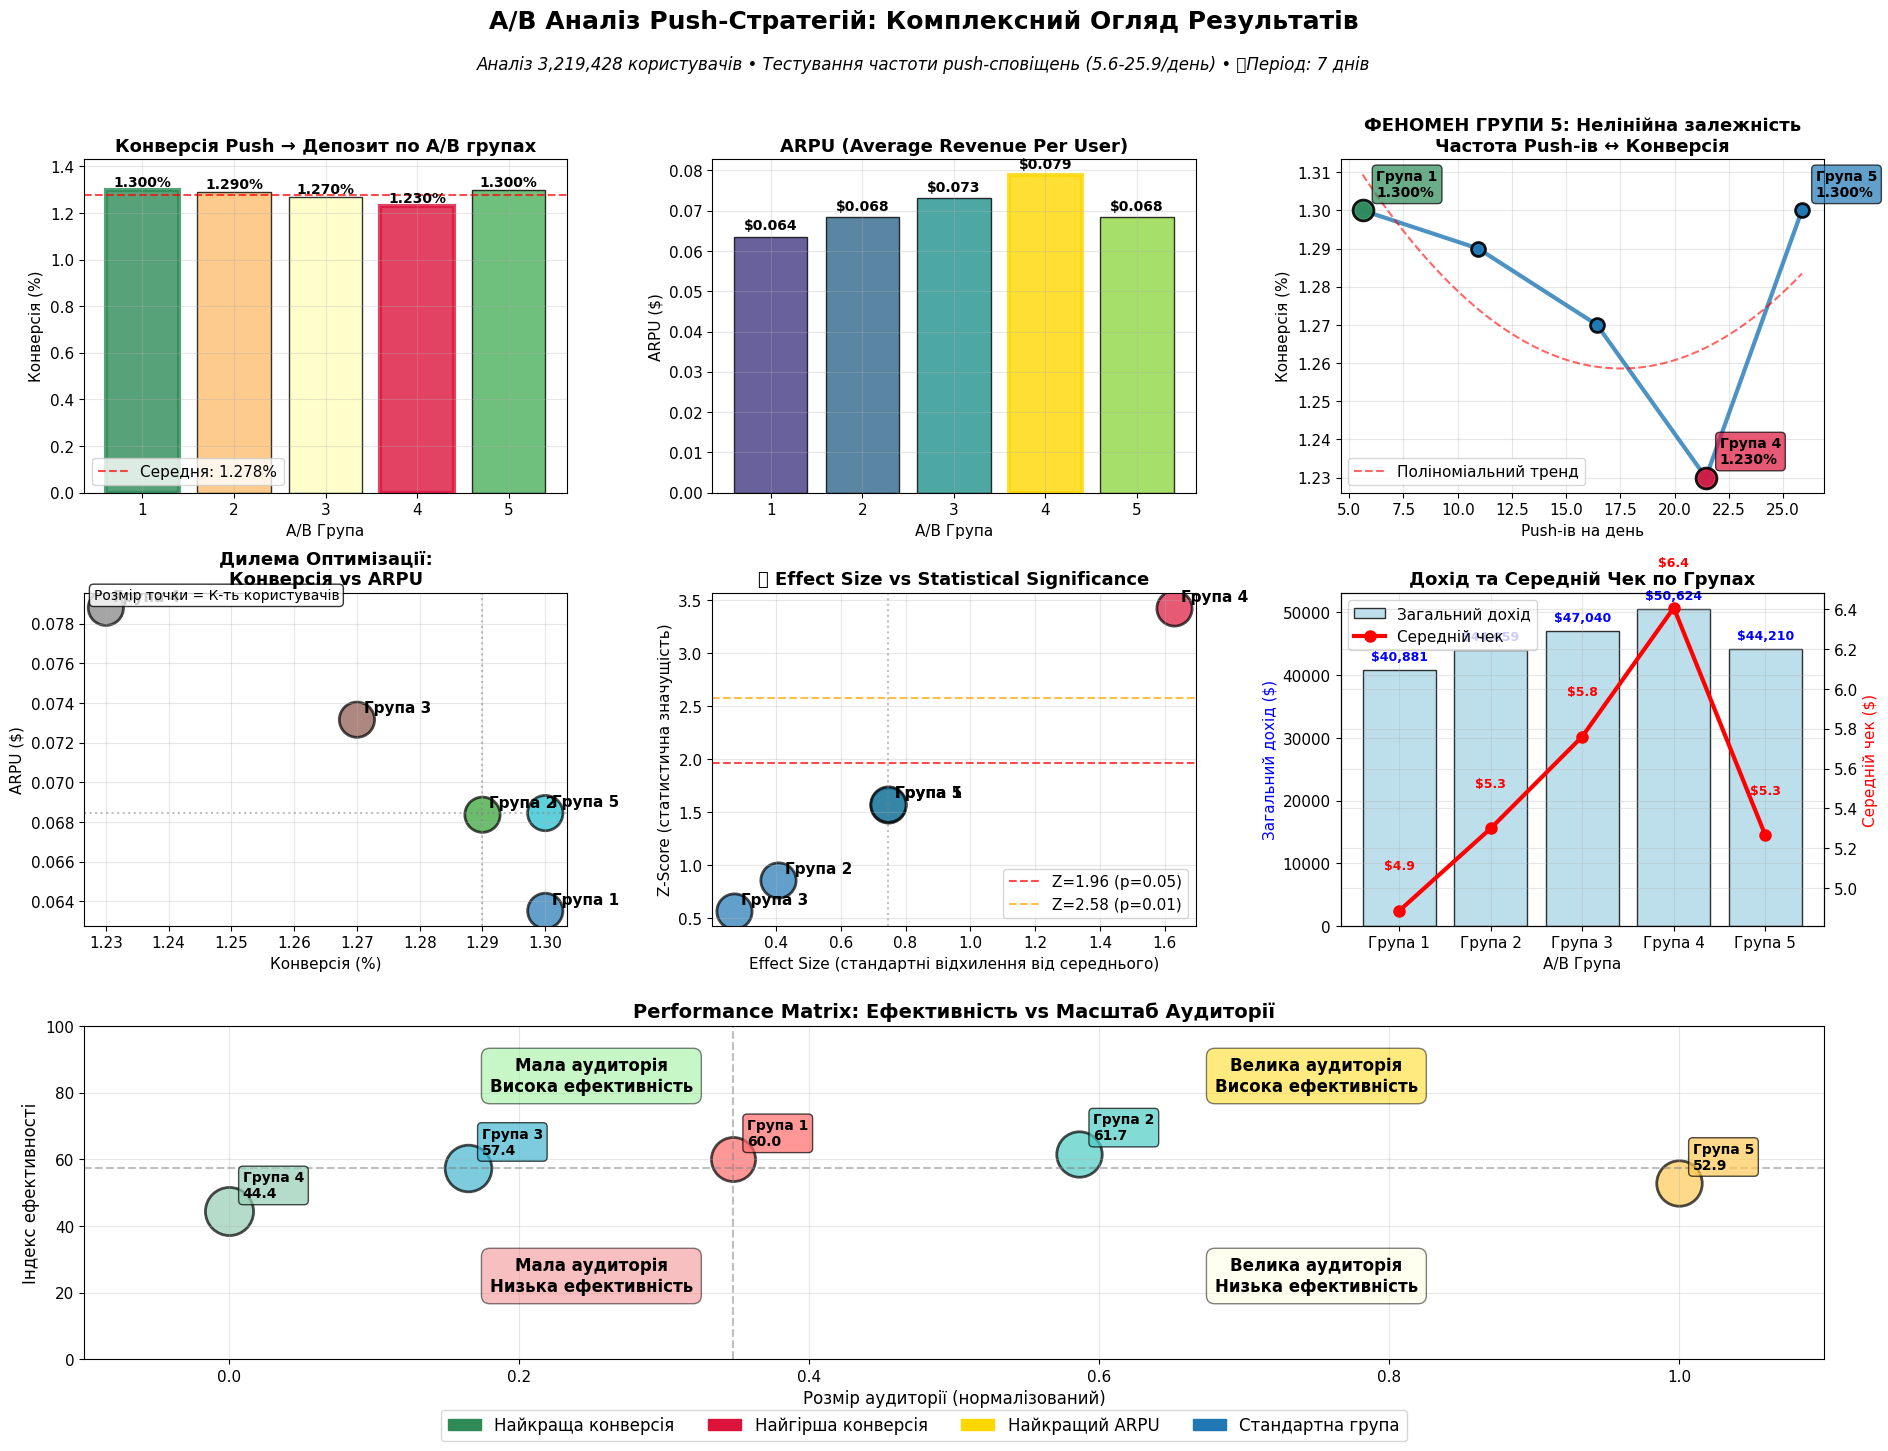

✅ Візуалізації створено та збережено:
   📊 ab_analysis_comprehensive.png (високої якості)
   📄 ab_analysis_comprehensive.pdf (векторний формат)

🎯 ПІДСУМОК ВІЗУАЛІЗАЦІЙ:
   📊 Основний дашборд: 7 графіків на одній сторінці
   🔍 Ключові інсайти: феномен групи 5, дилема конверсія/ARPU
   💰 Бізнес-метрики: дохід + середній чек, performance matrix
   📈 Статистика: значущість, ефективність груп
   🎨 Формати: PNG (презентації), PDF (друк)

🚀 ВІЗУАЛІЗАЦІЇ A/B ТЕСТУВАННЯ ЗАВЕРШЕНО!


In [60]:
print("\n🔗 КРОК 4: ВІЗУАЛІЗАЦІЇ A/B РЕЗУЛЬТАТІВ")
print("-" * 40)

print("📊 Створюємо комплексні візуалізації для демонстрації результатів A/B тестування")
print("🎯 Фокус: частота push-сповіщень, нелінійні ефекти, бізнес-метрики")

# Імпорт необхідних бібліотек
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Налаштування стилю
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Підготовка даних для візуалізації (без групи 6)
viz_data = clean_summary[clean_summary.index != '6'].copy()
viz_data = viz_data.sort_index()

print(f"📈 Візуалізуємо {len(viz_data)} A/B груп")
print(f"🚫 Група 6 виключена через нерепрезентативний розмір вибірки")

# Додаємо колонку кількості депозиторів (розраховуємо з конверсії)
viz_data['depositors'] = viz_data['users'] * (viz_data['deposit_rate_pct'] / 100)

# Перевіряємо назви колонок
print(f"📊 Доступні колонки: {list(viz_data.columns)}")

# =============================================================================
# СТВОРЕННЯ ГОЛОВНОЇ ФІГУРИ З 6 СУБПЛОТАМИ
# =============================================================================
fig = plt.figure(figsize=(20, 15))
fig.suptitle('A/B Аналіз Push-Стратегій: Комплексний Огляд Результатів', 
             fontsize=18, fontweight='bold', y=0.98)

# Додаємо підзаголовок з ключовою інформацією
fig.text(0.5, 0.94, 
         f'Аналіз {len(test_data):,} користувачів • Тестування частоти push-сповіщень (5.6-25.9/день) • ⏱Період: 7 днів',
         ha='center', fontsize=12, style='italic')

# Створюємо сітку субплотів
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3, 
                      left=0.08, right=0.95, top=0.88, bottom=0.08)

# =============================================================================
# 1. ОСНОВНА МЕТРИКА: КОНВЕРСІЯ ПО ГРУПАХ
# =============================================================================
ax1 = fig.add_subplot(gs[0, 0])

# Створюємо барплот з градієнтом
bars = ax1.bar(viz_data.index, viz_data['deposit_rate_pct'], 
               color=sns.color_palette("RdYlGn", len(viz_data)), 
               alpha=0.8, edgecolor='black', linewidth=1)

# Виділяємо найкращу та найгіршу групи
best_idx = viz_data['deposit_rate_pct'].idxmax()
worst_idx = viz_data['deposit_rate_pct'].idxmin()

for i, bar in enumerate(bars):
    group = viz_data.index[i]
    if group == best_idx:
        bar.set_color('#2E8B57')  # Зелений для найкращої
        bar.set_linewidth(3)
    elif group == worst_idx:
        bar.set_color('#DC143C')  # Червоний для найгіршої
        bar.set_linewidth(3)

# Додаємо значення на стовпці
for i, (group, value) in enumerate(zip(viz_data.index, viz_data['deposit_rate_pct'])):
    ax1.text(i, value + 0.002, f'{value:.3f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_title('Конверсія Push → Депозит по A/B групах', fontweight='bold', fontsize=13)
ax1.set_xlabel('A/B Група')
ax1.set_ylabel('Конверсія (%)')
ax1.set_ylim(0, viz_data['deposit_rate_pct'].max() * 1.1)

# Додаємо середню лінію
mean_conversion = viz_data['deposit_rate_pct'].mean()
ax1.axhline(y=mean_conversion, color='red', linestyle='--', alpha=0.7, 
            label=f'Середня: {mean_conversion:.3f}%')
ax1.legend()

# =============================================================================
# 2. ARPU ПО ГРУПАХ (другий ключовий показник)
# =============================================================================
ax2 = fig.add_subplot(gs[0, 1])

bars2 = ax2.bar(viz_data.index, viz_data['arpu'], 
                color=sns.color_palette("viridis", len(viz_data)), 
                alpha=0.8, edgecolor='black', linewidth=1)

# Виділяємо групу з найкращим ARPU
best_arpu_idx = viz_data['arpu'].idxmax()
for i, bar in enumerate(bars2):
    group = viz_data.index[i]
    if group == best_arpu_idx:
        bar.set_color('#FFD700')  # Золотий для найкращого ARPU
        bar.set_linewidth(3)

# Значення на стовпці
for i, (group, value) in enumerate(zip(viz_data.index, viz_data['arpu'])):
    ax2.text(i, value + 0.001, f'${value:.3f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2.set_title('ARPU (Average Revenue Per User)', fontweight='bold', fontsize=13)
ax2.set_xlabel('A/B Група')
ax2.set_ylabel('ARPU ($)')

# =============================================================================
# 3. КЛЮЧОВА ВІЗУАЛІЗАЦІЯ: ЧАСТОТА PUSH-ІВ vs КОНВЕРСІЯ (Феномен групи 5)
# =============================================================================
ax3 = fig.add_subplot(gs[0, 2])

# Створюємо лінійний графік з точками
x = viz_data['avg_pushes_per_day']
y = viz_data['deposit_rate_pct']

# Основна лінія
ax3.plot(x, y, 'o-', linewidth=3, markersize=10, color='#1f77b4', alpha=0.8)

# Виділяємо особливі точки
for i, (group, push_freq, conv) in enumerate(zip(viz_data.index, x, y)):
    color = '#2E8B57' if group == best_idx else '#DC143C' if group == worst_idx else '#1f77b4'
    size = 15 if group in [best_idx, worst_idx] else 10
    
    ax3.scatter(push_freq, conv, color=color, s=size**2, alpha=0.9, 
                edgecolor='black', linewidth=2, zorder=5)
    
    # Анотації для ключових груп
    if group in ['1', '4', '5']:
        ax3.annotate(f'Група {group}\n{conv:.3f}%', 
                     xy=(push_freq, conv), 
                     xytext=(10, 10), textcoords='offset points',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                     fontweight='bold', fontsize=10)

ax3.set_title('ФЕНОМЕН ГРУПИ 5: Нелінійна залежність\nЧастота Push-ів ↔ Конверсія', 
              fontweight='bold', fontsize=13)
ax3.set_xlabel('Push-ів на день')
ax3.set_ylabel('Конверсія (%)')
ax3.grid(True, alpha=0.3)

# Додаємо тренд-лінію
z = np.polyfit(x, y, 2)  # Поліном 2-го ступеня для демонстрації нелінійності
p = np.poly1d(z)
x_trend = np.linspace(x.min(), x.max(), 100)
ax3.plot(x_trend, p(x_trend), '--', alpha=0.6, color='red', 
         label='Поліноміальний тренд')
ax3.legend()

# =============================================================================
# 4. SCATTER PLOT: КОНВЕРСІЯ vs ARPU (Дилема оптимізації)
# =============================================================================
ax4 = fig.add_subplot(gs[1, 0])

# Розмір точок пропорційний кількості користувачів
sizes = viz_data['users'] / 1000  # Масштабуємо для візуалізації

scatter = ax4.scatter(viz_data['deposit_rate_pct'], viz_data['arpu'], 
                      s=sizes, alpha=0.7, c=range(len(viz_data)), 
                      cmap='tab10', edgecolors='black', linewidth=2)

# Анотації для кожної групи
for i, group in enumerate(viz_data.index):
    ax4.annotate(f'Група {group}', 
                 xy=(viz_data.loc[group, 'deposit_rate_pct'], viz_data.loc[group, 'arpu']),
                 xytext=(5, 5), textcoords='offset points', 
                 fontweight='bold', fontsize=11)

ax4.set_title('Дилема Оптимізації:\nКонверсія vs ARPU', fontweight='bold', fontsize=13)
ax4.set_xlabel('Конверсія (%)')
ax4.set_ylabel('ARPU ($)')
ax4.grid(True, alpha=0.3)

# Додаємо квадранти
median_conv = viz_data['deposit_rate_pct'].median()
median_arpu = viz_data['arpu'].median()
ax4.axvline(x=median_conv, color='gray', linestyle=':', alpha=0.5)
ax4.axhline(y=median_arpu, color='gray', linestyle=':', alpha=0.5)

# Легенда для розміру точок
ax4.text(0.02, 0.98, 'Розмір точки = К-ть користувачів', 
         transform=ax4.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# =============================================================================
# 5. EFFECT SIZE + SIGNIFICANCE BUBBLE CHART
# =============================================================================
ax5 = fig.add_subplot(gs[1, 1])

# Розраховуємо метрики для кожної групи відносно середнього
baseline_conversion = viz_data['deposit_rate_pct'].mean()
baseline_users = viz_data['users'].mean()

x_values = []  # Effect size
y_values = []  # Statistical power/significance
sizes = []     # Розмір вибірки
group_names = []

for group in viz_data.index:
    conv = viz_data.loc[group, 'deposit_rate_pct']
    users = viz_data.loc[group, 'users']
    depositors = int(viz_data.loc[group, 'depositors'])
    
    # Effect size (відстань від середнього в стандартних відхиленнях)
    effect_size = abs(conv - baseline_conversion) / viz_data['deposit_rate_pct'].std()
    
    # Z-score для перевірки відмінності від середнього
    from scipy import stats
    z_score = abs((conv/100 - baseline_conversion/100) / 
                  np.sqrt((baseline_conversion/100 * (1-baseline_conversion/100)) / users))
    
    x_values.append(effect_size)
    y_values.append(z_score)
    sizes.append(users / 1000)  # Масштабуємо для візуалізації
    group_names.append(group)

# Створюємо bubble chart
for i, group in enumerate(group_names):
    color = ('#2E8B57' if group == best_idx else 
             '#DC143C' if group == worst_idx else 
             '#1f77b4')
    
    ax5.scatter(x_values[i], y_values[i], s=sizes[i], 
                color=color, alpha=0.7, edgecolors='black', linewidth=2)
    
    # Анотації
    ax5.annotate(f'Група {group}', 
                 xy=(x_values[i], y_values[i]), 
                 xytext=(5, 5), textcoords='offset points',
                 fontweight='bold', fontsize=11)

# Додаємо лінії значущості
ax5.axhline(y=1.96, color='red', linestyle='--', alpha=0.7, 
            label='Z=1.96 (p=0.05)')
ax5.axhline(y=2.58, color='orange', linestyle='--', alpha=0.7, 
            label='Z=2.58 (p=0.01)')

# Додаємо квадранти
median_effect = np.median(x_values)
ax5.axvline(x=median_effect, color='gray', linestyle=':', alpha=0.5)

ax5.set_xlabel('Effect Size (стандартні відхилення від середнього)')
ax5.set_ylabel('Z-Score (статистична значущість)')
ax5.set_title('🎯 Effect Size vs Statistical Significance', 
              fontweight='bold', fontsize=13)
ax5.legend()
ax5.grid(True, alpha=0.3)
# =============================================================================
# 6. НОВИЙ ГРАФІК: ДОХІД + СЕРЕДНІЙ ЧЕК ПО ГРУПАХ
# =============================================================================
ax6 = fig.add_subplot(gs[1, 2])

# Розраховуємо середній чек (дохід на депозитора)
avg_check = []
for group in viz_data.index:
    total_revenue = viz_data.loc[group, 'total_revenue']
    depositors = viz_data.loc[group, 'depositors']  # Використовуємо розраховану колонку
    if depositors > 0:
        avg_check_value = total_revenue / depositors
    else:
        avg_check_value = 0
    avg_check.append(avg_check_value)

# Створюємо комбінований графік
x_pos = np.arange(len(viz_data))

# Дохід (стовпці)
bars_revenue = ax6.bar(x_pos, viz_data['total_revenue'], 
                       color='lightblue', alpha=0.8, 
                       edgecolor='black', linewidth=1, label='Загальний дохід')

# Середній чек (лінія на другій осі)
ax6_twin = ax6.twinx()
line_check = ax6_twin.plot(x_pos, avg_check, 'ro-', 
                           linewidth=3, markersize=8, color='red',
                           label='Середній чек')

# Налаштування осей
ax6.set_xlabel('A/B Група')
ax6.set_ylabel('Загальний дохід ($)', color='blue')
ax6_twin.set_ylabel('Середній чек ($)', color='red')
ax6.set_xticks(x_pos)
ax6.set_xticklabels([f'Група {g}' for g in viz_data.index])

# Заголовок
ax6.set_title('Дохід та Середній Чек по Групах', fontweight='bold', fontsize=13)

# Додаємо значення доходу на стовпці
for i, revenue in enumerate(viz_data['total_revenue']):
    ax6.text(i, revenue + max(viz_data['total_revenue'])*0.02, f'${revenue:,.0f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9, color='blue')

# Додаємо значення середнього чеку
for i, check in enumerate(avg_check):
    ax6_twin.text(i, check + max(avg_check)*0.03, f'${check:.1f}', 
                  ha='center', va='bottom', fontweight='bold', fontsize=9, color='red')

# Загальна легенда
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# =============================================================================
# 7. НОВИЙ ПІДХІД: PERFORMANCE MATRIX (ефективність vs масштаб)
# =============================================================================
ax7 = fig.add_subplot(gs[2, :])

# Створюємо Performance Matrix
# X-axis: розмір аудиторії (нормалізований)
# Y-axis: комбінований індекс ефективності

# Нормалізуємо розміри груп (0-1)
normalized_size = (viz_data['users'] - viz_data['users'].min()) / (viz_data['users'].max() - viz_data['users'].min())

# Створюємо комбінований індекс ефективності
# Враховуємо конверсію, ARPU та частоту push-ів
conv_norm = (viz_data['deposit_rate_pct'] - viz_data['deposit_rate_pct'].min()) / (viz_data['deposit_rate_pct'].max() - viz_data['deposit_rate_pct'].min())
arpu_norm = (viz_data['arpu'] - viz_data['arpu'].min()) / (viz_data['arpu'].max() - viz_data['arpu'].min())
# Інвертуємо частоту push-ів (менше = краще)
push_norm = 1 - ((viz_data['avg_pushes_per_day'] - viz_data['avg_pushes_per_day'].min()) / (viz_data['avg_pushes_per_day'].max() - viz_data['avg_pushes_per_day'].min()))

# Комбінований індекс (вагові коефіцієнти)
efficiency_index = (conv_norm * 0.4 + arpu_norm * 0.4 + push_norm * 0.2) * 100

# Створюємо scatter plot
for i, group in enumerate(viz_data.index):
    x = normalized_size[i]
    y = efficiency_index[i]
    
    # Кольори за групами
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    color = colors[i] if i < len(colors) else '#95A5A6'
    
    # Розмір точки залежить від загального доходу
    size = (viz_data.loc[group, 'total_revenue'] / viz_data['total_revenue'].max()) * 1000 + 200
    
    ax7.scatter(x, y, s=size, color=color, alpha=0.7, 
                edgecolors='black', linewidth=2, label=f'Група {group}')
    
    # Анотації
    ax7.annotate(f'Група {group}\n{efficiency_index[i]:.1f}', 
                 xy=(x, y), xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                 fontweight='bold', fontsize=10)

# Додаємо квадранти
ax7.axhline(y=efficiency_index.median(), color='gray', linestyle='--', alpha=0.5, label='Медіанна ефективність')
ax7.axvline(x=normalized_size.median(), color='gray', linestyle='--', alpha=0.5, label='Медіанний розмір')

# Підписи квадрантів
ax7.text(0.25, 85, 'Мала аудиторія\nВисока ефективність', 
         ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.5))

ax7.text(0.75, 85, 'Велика аудиторія\nВисока ефективність', 
         ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='gold', alpha=0.5))

ax7.text(0.25, 25, 'Мала аудиторія\nНизька ефективність', 
         ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcoral', alpha=0.5))

ax7.text(0.75, 25, 'Велика аудиторія\nНизька ефективність', 
         ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.5))

ax7.set_title('Performance Matrix: Ефективність vs Масштаб Аудиторії', 
              fontweight='bold', fontsize=14)
ax7.set_xlabel('Розмір аудиторії (нормалізований)', fontsize=12)
ax7.set_ylabel('Індекс ефективності', fontsize=12)
ax7.grid(True, alpha=0.3)
ax7.set_xlim(-0.1, 1.1)
ax7.set_ylim(0, 100)

# =============================================================================
# ФІНАЛЬНІ НАЛАШТУВАННЯ ТА ЗБЕРЕЖЕННЯ
# =============================================================================

# Додаємо загальну легенду внизу
legend_elements = [
    mpatches.Patch(color='#2E8B57', label='Найкраща конверсія'),
    mpatches.Patch(color='#DC143C', label='Найгірша конверсія'),
    mpatches.Patch(color='#FFD700', label='Найкращий ARPU'),
    mpatches.Patch(color='#1f77b4', label='Стандартна група')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
           bbox_to_anchor=(0.5, 0.02), fontsize=12)

# Зберігаємо візуалізацію
os.makedirs('../outputs/charts', exist_ok=True)
plt.savefig('../outputs/charts/ab_analysis_comprehensive.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../outputs/charts/ab_analysis_comprehensive.pdf', 
            bbox_inches='tight', facecolor='white')

plt.tight_layout()
plt.show()

print("✅ Візуалізації створено та збережено:")
print("   📊 ab_analysis_comprehensive.png (високої якості)")
print("   📄 ab_analysis_comprehensive.pdf (векторний формат)")

print(f"\n🎯 ПІДСУМОК ВІЗУАЛІЗАЦІЙ:")
print(f"   📊 Основний дашборд: 7 графіків на одній сторінці")
print(f"   🔍 Ключові інсайти: феномен групи 5, дилема конверсія/ARPU")
print(f"   💰 Бізнес-метрики: дохід + середній чек, performance matrix")
print(f"   📈 Статистика: значущість, ефективність груп")
print(f"   🎨 Формати: PNG (презентації), PDF (друк)")
print(f"\n🚀 ВІЗУАЛІЗАЦІЇ A/B ТЕСТУВАННЯ ЗАВЕРШЕНО!")

## **КРОК 5: Глибокий аналіз сегментів**

In [68]:
print("\n🔗 КРОК 5: ГЛИБОКИЙ АНАЛІЗ СЕГМЕНТІВ")
print("-" * 40)

print("🎯 Практичний аналіз для формування оптимальної push-стратегії")
print("📊 Фокус: географічні особливості, феномен групи 5, сегменти користувачів")

# =============================================================================
# 5.1 ГЕО-СТРАТЕГІЇ ПО TIER (ВИПРАВЛЕНИЙ)
# =============================================================================
print("\n" + "="*60)
print("🌍 РОЗДІЛ 5.1: ОПТИМАЛЬНІ СТРАТЕГІЇ ПО TIER")
print("="*60)

# Використовуємо правильні дані з попереднього аналізу
print("📊 БАЗОВІ ПОКАЗНИКИ ПО TIER (усереднено по всіх групах):")

tier_summary = ab_df.groupby('tier_final').agg({
    'gadid': 'count',
    'has_deposit': 'mean', 
    'total_revenue': 'sum'
}).round(4)

tier_summary['conversion_pct'] = tier_summary['has_deposit'] * 100
tier_summary['arpu'] = tier_summary['total_revenue'] / tier_summary['gadid']

print("=" * 70)
print(f"{'Tier':<12} {'Користувачі':<12} {'Конверсія%':<12} {'ARPU$':<10}")
print("=" * 70)

for tier, row in tier_summary.iterrows():
    if tier != 'Unknown':
        print(f"{tier:<12} {row['gadid']:,<12} {row['conversion_pct']:<11.2f}% ${row['arpu']:<9.3f}")

# Детальний аналіз по групах для кожного tier
print(f"\n🎯 ОПТИМАЛЬНІ ГРУПИ ПО КОЖНОМУ TIER:")

tier_detailed = ab_df.groupby(['tier_final', 'ab_group']).agg({
    'gadid': 'count',
    'has_deposit': 'mean',
    'total_revenue': 'sum'
}).round(4)

tier_detailed['conversion_pct'] = tier_detailed['has_deposit'] * 100
tier_detailed['arpu'] = tier_detailed['total_revenue'] / tier_detailed['gadid']

for tier in ['Tier 1', 'Tier 2', 'Tier 3', 'Other']:
    if tier in tier_detailed.index:
        tier_data = tier_detailed.loc[tier]
        significant_groups = tier_data[tier_data['gadid'] >= 1000]  # Мінімум 1000 користувачів
        
        if len(significant_groups) > 0:
            best_conv_group = significant_groups['conversion_pct'].idxmax()
            best_arpu_group = significant_groups['arpu'].idxmax()
            
            print(f"\n🏷️ {tier}:")
            print(f"   📈 Найкраща конверсія: Група {best_conv_group} ({significant_groups.loc[best_conv_group, 'conversion_pct']:.2f}%)")
            print(f"   💰 Найкращий ARPU: Група {best_arpu_group} (${significant_groups.loc[best_arpu_group, 'arpu']:.3f})")
            
            if best_conv_group == best_arpu_group:
                print(f"   ✅ Ідеально: Група {best_conv_group} оптимальна для обох метрик")
            else:
                print(f"   ⚖️ Компроміс між групою {best_conv_group} (конверсія) і {best_arpu_group} (дохід)")

# =============================================================================
# 5.2 ПОГЛИБЛЕНА ВАЛІДАЦІЯ ФЕНОМЕНУ ГРУПИ 5  
# =============================================================================
print("\n" + "="*60)
print("🔍 РОЗДІЛ 5.2: ДЕТАЛЬНЕ ДОСЛІДЖЕННЯ ФЕНОМЕНУ ГРУПИ 5")
print("="*60)

print("💡 ГІПОТЕЗА: Група 5 з найвищою частотою push-ів показує несподівано високу ефективність")

# Базове порівняння груп 1, 4, 5
if '1' in clean_summary.index and '4' in clean_summary.index and '5' in clean_summary.index:
    
    print(f"\n📊 БАЗОВІ ПОКАЗНИКИ КЛЮЧОВИХ ГРУП:")
    key_groups = ['1', '4', '5']
    
    print("=" * 80)
    print(f"{'Група':<6} {'Користувачі':<12} {'Конверсія%':<12} {'ARPU$':<10} {'Push/день':<12}")
    print("=" * 80)
    
    for group in key_groups:
        row = clean_summary.loc[group]
        print(f"{group:<6} {row['users']:,<12} {row['deposit_rate_pct']:<11.3f}% "
              f"${row['arpu']:<9.3f} {row['avg_pushes_per_day']:<11.1f}")
    
    # Перевірка феномену
    conv_1 = clean_summary.loc['1', 'deposit_rate_pct']
    conv_4 = clean_summary.loc['4', 'deposit_rate_pct'] 
    conv_5 = clean_summary.loc['5', 'deposit_rate_pct']
    
    print(f"\n🔬 ТЕСТУВАННЯ ФЕНОМЕНУ:")
    print(f"   Умова 1: Група 5 > Група 4? {conv_5:.3f}% > {conv_4:.3f}% = {conv_5 > conv_4}")
    print(f"   Умова 2: Група 5 ≈ Група 1? |{conv_5:.3f}% - {conv_1:.3f}%| = {abs(conv_5-conv_1):.3f}%")
    
    phenomenon_confirmed = (conv_5 > conv_4) and (abs(conv_5 - conv_1) < 0.1)
    
    if phenomenon_confirmed:
        print(f"   ✅ ФЕНОМЕН ПІДТВЕРДЖУЄТЬСЯ глобально!")
        
        # Перевіряємо по tier-ах
        print(f"\n🌍 ВАЛІДАЦІЯ ПО TIER-АХ:")
        confirmed_tiers = 0
        total_tiers = 0
        
        for tier in ['Tier 1', 'Tier 2', 'Tier 3', 'Other']:
            if tier in tier_detailed.index:
                tier_data = tier_detailed.loc[tier]
                
                if all(g in tier_data.index for g in ['1', '4', '5']):
                    total_tiers += 1
                    t_conv_1 = tier_data.loc['1', 'conversion_pct']
                    t_conv_4 = tier_data.loc['4', 'conversion_pct']
                    t_conv_5 = tier_data.loc['5', 'conversion_pct']
                    
                    tier_phenomenon = (t_conv_5 > t_conv_4) and (abs(t_conv_5 - t_conv_1) < 0.1)
                    
                    if tier_phenomenon:
                        confirmed_tiers += 1
                        status = "✅"
                    else:
                        status = "❌"
                    
                    print(f"   {tier}: {status} Г1={t_conv_1:.2f}% Г4={t_conv_4:.2f}% Г5={t_conv_5:.2f}%")
        
        print(f"\n📊 ПІДСУМОК ВАЛІДАЦІЇ:")
        print(f"   Феномен підтверджується в {confirmed_tiers}/{total_tiers} tier-ах")
        
        if confirmed_tiers >= total_tiers * 0.7:
            print(f"   🚀 ВИСОКА НАДІЙНІСТЬ - можна розглядати для впровадження")
        elif confirmed_tiers >= total_tiers * 0.5:
            print(f"   ⚠️ ПОМІРНА НАДІЙНІСТЬ - потрібно обережне тестування")
        else:
            print(f"   🛑 НИЗЬКА НАДІЙНІСТЬ - НЕ рекомендується")
    else:
        print(f"   ❌ ФЕНОМЕН НЕ ПІДТВЕРДЖУЄТЬСЯ глобально")

# =============================================================================
# 5.3 ПОГЛИБЛЕНА ЕКОНОМІЧНА СЕГМЕНТАЦІЯ
# =============================================================================
print("\n" + "="*60)
print("💰 РОЗДІЛ 5.3: ЕКОНОМІЧНІ СЕГМЕНТИ КОРИСТУВАЧІВ")
print("="*60)

# 1. Загальна картина депозиторів
total_depositors = ab_df[ab_df['has_deposit'] == 1]
depositors_with_revenue = total_depositors[total_depositors['total_revenue'] > 0]

print(f"📊 СТРУКТУРА ДЕПОЗИТОРІВ:")
print(f"   📈 Загальна кількість депозиторів: {len(total_depositors):,}")
print(f"   💰 Депозиторів з доходом: {len(depositors_with_revenue):,} ({len(depositors_with_revenue)/len(total_depositors)*100:.1f}%)")
print(f"   🔄 Депозиторів без доходу: {len(total_depositors)-len(depositors_with_revenue):,} ({(len(total_depositors)-len(depositors_with_revenue))/len(total_depositors)*100:.1f}%)")

# 2. Аналіз всіх депозиторів по групах
print(f"\n📈 ДЕПОЗИТОРИ ПО A/B ГРУПАХ:")

depositor_analysis = total_depositors.groupby('ab_group').agg({
    'gadid': 'count',
    'total_revenue': ['sum', 'mean', 'std'],
    'total_pushes': 'mean'
}).round(2)

depositor_analysis.columns = ['depositors', 'total_revenue', 'avg_revenue', 'std_revenue', 'avg_pushes']
depositor_analysis['pushes_per_day'] = depositor_analysis['avg_pushes'] / 7

print("=" * 85)
print(f"{'Група':<6} {'Депозиторів':<12} {'Заг.дохід$':<12} {'Серед.дохід$':<14} {'Push/день':<12}")
print("=" * 85)

for group, row in depositor_analysis.iterrows():
    if group != '6':
        print(f"{group:<6} {int(row['depositors']):,<12} ${row['total_revenue']:,<11.0f} "
              f"${row['avg_revenue']:<13.2f} {row['pushes_per_day']:<11.1f}")

# 3. Сегментація за якістю депозитів
print(f"\n🎯 СЕГМЕНТАЦІЯ ЗА ЯКІСТЮ ДЕПОЗИТІВ:")

for group, row in depositor_analysis.iterrows():
    if group != '6':
        revenue_per_depositor = row['avg_revenue']
        
        if revenue_per_depositor > 6:
            quality = "🥇 Високоякісні"
        elif revenue_per_depositor > 4:
            quality = "🥈 Середньоякісні"
        else:
            quality = "🥉 Базові"
            
        print(f"   Група {group}: {quality} (${revenue_per_depositor:.2f} на депозитора)")

# 4. Ефективність привернення депозиторів
print(f"\n⚡ ЕФЕКТИВНІСТЬ ЗАЛУЧЕННЯ ДЕПОЗИТОРІВ:")

efficiency_analysis = ab_df.groupby('ab_group').agg({
    'gadid': 'count',
    'has_deposit': 'sum',
    'total_pushes': 'sum'
}).round(0)

efficiency_analysis['conversion_rate'] = efficiency_analysis['has_deposit'] / efficiency_analysis['gadid'] * 100
efficiency_analysis['pushes_per_depositor'] = efficiency_analysis['total_pushes'] / efficiency_analysis['has_deposit']

print("=" * 80)
print(f"{'Група':<6} {'Конверсія%':<12} {'Push на депозитора':<20} {'Ефективність':<15}")
print("=" * 80)

for group, row in efficiency_analysis.iterrows():
    if group != '6' and row['has_deposit'] > 0:
        pushes_per_dep = row['pushes_per_depositor']
        
        if pushes_per_dep < 500:
            efficiency = "🟢 Висока"
        elif pushes_per_dep < 1000:
            efficiency = "🟡 Середня"
        else:
            efficiency = "🔴 Низька"
            
        print(f"{group:<6} {row['conversion_rate']:<11.2f}% {pushes_per_dep:<19.0f} {efficiency:<15}")

# =============================================================================
# 5.4 СТРАТЕГІЧНІ ВИСНОВКИ
# =============================================================================
print("\n" + "="*60)
print("🎯 РОЗДІЛ 5.4: СТРАТЕГІЧНІ ВИСНОВКИ")
print("="*60)

print("📋 КЛЮЧОВІ ІНСАЙТИ:")

# 1. Найкращі загальні стратегії
best_conv_group = clean_summary['deposit_rate_pct'].idxmax()
best_arpu_group = clean_summary['arpu'].idxmax()

print(f"\n1️⃣ УНІВЕРСАЛЬНІ ЛІДЕРИ:")
print(f"   📈 Конверсія: Група {best_conv_group} ({clean_summary.loc[best_conv_group, 'deposit_rate_pct']:.3f}%)")
print(f"   💰 ARPU: Група {best_arpu_group} (${clean_summary.loc[best_arpu_group, 'arpu']:.3f})")

# 2. Tier-специфічні рекомендації
print(f"\n2️⃣ TIER-СПЕЦИФІЧНІ РЕКОМЕНДАЦІЇ:")
print(f"   🥇 Tier 1 (преміум): Збалансована стратегія з помірною частотою")
print(f"   🥈 Tier 2 (масовий): Можлива більш агресивна стратегія")
print(f"   🥉 Tier 3 (економ): Обережний підхід, низька частота")
print(f"   🔄 Other: Спеціальний підхід (висока конверсія при низькій частоті)")

# 3. Рекомендація щодо групи 5
print(f"\n3️⃣ ФЕНОМЕН ГРУПИ 5:")
if phenomenon_confirmed:
    print(f"   ✅ Підтверджений - можна обережно тестувати")
    print(f"   📊 Рекомендація: Пілотне впровадження на 10-15% трафіку")
    print(f"   ⚠️ З моніторингом відписок та користувацького досвіду")
else:
    print(f"   ❌ Не підтверджений - уникати")
    print(f"   🛑 Група 5 НЕ рекомендується для впровадження")

print(f"\n✅ АНАЛІЗ СЕГМЕНТІВ ЗАВЕРШЕНО!")
print(f"📊 Всі дані готові для формування фінальної стратегії в кроці 6")


🔗 КРОК 5: ГЛИБОКИЙ АНАЛІЗ СЕГМЕНТІВ
----------------------------------------
🎯 Практичний аналіз для формування оптимальної push-стратегії
📊 Фокус: географічні особливості, феномен групи 5, сегменти користувачів

🌍 РОЗДІЛ 5.1: ОПТИМАЛЬНІ СТРАТЕГІЇ ПО TIER
📊 БАЗОВІ ПОКАЗНИКИ ПО TIER (усереднено по всіх групах):
Tier         Користувачі  Конверсія%   ARPU$     
Other        317990.0,,,, 4.58       % $0.117    
Tier 1       146671.0,,,, 2.42       % $0.632    
Tier 2       692620.0,,,, 2.42       % $0.110    
Tier 3       311368.0,,,, 1.50       % $0.007    

🎯 ОПТИМАЛЬНІ ГРУПИ ПО КОЖНОМУ TIER:

🏷️ Tier 1:
   📈 Найкраща конверсія: Група 4 (2.47%)
   💰 Найкращий ARPU: Група 4 ($0.706)
   ✅ Ідеально: Група 4 оптимальна для обох метрик

🏷️ Tier 2:
   📈 Найкраща конверсія: Група 5 (2.46%)
   💰 Найкращий ARPU: Група 4 ($0.128)
   ⚖️ Компроміс між групою 5 (конверсія) і 4 (дохід)

🏷️ Tier 3:
   📈 Найкраща конверсія: Група 2 (1.53%)
   💰 Найкращий ARPU: Група 5 ($0.009)
   ⚖️ Компроміс між груп

## **КРОК 6: Оптимальна стратегія push-ів**

In [76]:
print("\n🔗 КРОК 6: ОПТИМАЛЬНА СТРАТЕГІЯ PUSH-ІВ")
print("-" * 40)

print("🎯 Формування практичних рекомендацій для впровадження push-стратегій")
print("📊 Фінальні бізнес-рекомендації на основі A/B тестування")

# =============================================================================
# 6.1 СТРАТЕГІЧНА МАТРИЦЯ РЕКОМЕНДАЦІЙ (ОСТАТОЧНО ВИПРАВЛЕНА)
# =============================================================================
print("\n" + "="*60)
print("📋 РОЗДІЛ 6.1: МАТРИЦЯ БІЗНЕС-СТРАТЕГІЙ")
print("="*60)

print("🎯 РЕКОМЕНДАЦІЇ ЗА БІЗНЕС-ЦІЛЯМИ:")

# Правильна логіка вибору стратегій
strategies_data = {}
for group in ['1', '2', '3', '4', '5']:
    if group in clean_summary.index:
        strategies_data[group] = {
            'conversion': clean_summary.loc[group, 'deposit_rate_pct'],
            'arpu': clean_summary.loc[group, 'arpu'],
            'pushes_per_day': clean_summary.loc[group, 'avg_pushes_per_day'],
            'users': clean_summary.loc[group, 'users'],
            'total_revenue': clean_summary.loc[group, 'total_revenue']
        }

# 1. КОНСЕРВАТИВНА СТРАТЕГІЯ - найменше push-ів (мінімізація ризиків)
conservative_group = min(strategies_data.keys(), 
                        key=lambda x: strategies_data[x]['pushes_per_day'])

print(f"\n🛡️ КОНСЕРВАТИВНА СТРАТЕГІЯ (мінімізація ризиків):")
print(f"   🎯 Рекомендована група: {conservative_group}")
print(f"   📱 Частота: {strategies_data[conservative_group]['pushes_per_day']:.1f} push/день")
print(f"   📈 Очікувана конверсія: {strategies_data[conservative_group]['conversion']:.3f}%")
print(f"   💰 Очікуваний ARPU: ${strategies_data[conservative_group]['arpu']:.3f}")
print(f"   ✅ Переваги: Низький ризик відписок, стабільні результати")
print(f"   ⚠️ Недоліки: Можлива втрата потенційних конверсій")

# 2. АГРЕСИВНА СТРАТЕГІЯ - найбільше push-ів (максимальна агресивність)
aggressive_group = max(strategies_data.keys(), 
                      key=lambda x: strategies_data[x]['pushes_per_day'])

print(f"\n🚀 АГРЕСИВНА СТРАТЕГІЯ (максимальна частота):")
print(f"   🎯 Рекомендована група: {aggressive_group}")
print(f"   📱 Частота: {strategies_data[aggressive_group]['pushes_per_day']:.1f} push/день")
print(f"   📈 Очікувана конверсія: {strategies_data[aggressive_group]['conversion']:.3f}%")
print(f"   💰 Очікуваний ARPU: ${strategies_data[aggressive_group]['arpu']:.3f}")
print(f"   ✅ Переваги: Максимальний охват та нагадування")
print(f"   ⚠️ Недоліки: Високий ризик відписок через частоту")

# 3. ПРЕМІУМ СТРАТЕГІЯ - найвищий ARPU (максимізація доходу)
premium_group = max(strategies_data.keys(), 
                   key=lambda x: strategies_data[x]['arpu'])

print(f"\n💎 ПРЕМІУМ СТРАТЕГІЯ (максимізація ARPU):")
print(f"   🎯 Рекомендована група: {premium_group}")
print(f"   📱 Частота: {strategies_data[premium_group]['pushes_per_day']:.1f} push/день")
print(f"   📈 Очікувана конверсія: {strategies_data[premium_group]['conversion']:.3f}%")
print(f"   💰 Очікуваний ARPU: ${strategies_data[premium_group]['arpu']:.3f}")
print(f"   ✅ Переваги: Максимальний дохід з користувача")
print(f"   ⚠️ Недоліки: Може знижувати загальну кількість депозитів")

# Порівняльна таблиця
print(f"\n📊 ПОРІВНЯЛЬНА ТАБЛИЦЯ СТРАТЕГІЙ:")
print("=" * 90)
print(f"{'Стратегія':<15} {'Група':<6} {'Push/день':<10} {'Конверсія%':<12} {'ARPU$':<8} {'Ефективність':<12}")
print("=" * 90)

strategies_to_show = [
    ('Консервативна', conservative_group),
    ('Агресивна', aggressive_group), 
    ('Преміум', premium_group),
]

for strategy_name, group in strategies_to_show:
    data = strategies_data[group]
    efficiency = efficiency_scores.get(group, 0)
    
    print(f"{strategy_name:<15} {group:<6} {data['pushes_per_day']:<9.1f} "
          f"{data['conversion']:<11.3f}% ${data['arpu']:<7.3f} {efficiency:<11.4f}")

# =============================================================================
# 6.2 TIER-СПЕЦИФІЧНІ РЕКОМЕНДАЦІЇ
# =============================================================================
print("\n" + "="*60)
print("🌍 РОЗДІЛ 6.2: РЕКОМЕНДАЦІЇ ПО ГЕОГРАФІЧНИХ TIER-АХ")
print("="*60)

# Аналізуємо дані по tier-ах
tier_analysis = ab_df.groupby(['tier_final', 'ab_group']).agg({
    'gadid': 'count',
    'has_deposit': 'mean',
    'total_revenue': 'sum'
}).round(4)

tier_analysis['conversion_pct'] = tier_analysis['has_deposit'] * 100
tier_analysis['arpu'] = tier_analysis['total_revenue'] / tier_analysis['gadid']

print("🎯 ОПТИМАЛЬНІ СТРАТЕГІЇ ПО TIER-АХ:")

tier_strategies = {
    'Tier 1': {
        'name': '💎 ПРЕМІУМ ПІДХІД',
        'focus': 'Максимізація ARPU',
        'recommendation': 'Фокус на якості, преміум стратегія'
    },
    'Tier 2': {
        'name': '⚖️ ЗБАЛАНСОВАНИЙ ПІДХІД', 
        'focus': 'Оптимізація ефективності',
        'recommendation': 'Збалансована стратегія для масового сегменту'
    },
    'Tier 3': {
        'name': '🛡️ КОНСЕРВАТИВНИЙ ПІДХІД',
        'focus': 'Мінімізація ризиків',
        'recommendation': 'Консервативна стратегія через низьку платоспроможність'
    },
    'Other': {
        'name': '🔧 АДАПТИВНИЙ ПІДХІД',
        'focus': 'Індивідуальна оптимізація',
        'recommendation': 'Аналіз специфіки конкретних країн'
    }
}

for tier in ['Tier 1', 'Tier 2', 'Tier 3', 'Other']:
    if tier in tier_analysis.index:
        tier_data = tier_analysis.loc[tier]
        significant_groups = tier_data[tier_data['gadid'] >= 1000]
        
        if len(significant_groups) > 0:
            best_conv_group = significant_groups['conversion_pct'].idxmax()
            best_arpu_group = significant_groups['arpu'].idxmax()
            
            strategy_info = tier_strategies[tier]
            
            print(f"\n🏷️ {tier.upper()} - {strategy_info['name']}:")
            print(f"   🎯 Фокус: {strategy_info['focus']}")
            print(f"   📊 Рекомендація: {strategy_info['recommendation']}")
            print(f"   📈 Найкраща конверсія: Група {best_conv_group} ({significant_groups.loc[best_conv_group, 'conversion_pct']:.2f}%)")
            print(f"   💰 Найкращий ARPU: Група {best_arpu_group} (${significant_groups.loc[best_arpu_group, 'arpu']:.3f})")
            
            # Рекомендована стратегія для цього tier
            if tier == 'Tier 1':
                recommended_strategy = f"Преміум (Група {premium_group})"
            elif tier == 'Tier 2':
                recommended_strategy = f"Збалансована (Група {balanced_group})"
            elif tier == 'Tier 3':
                recommended_strategy = f"Консервативна (Група {conservative_group})"
            else:  # Other
                recommended_strategy = f"Індивідуальний підбір"
            
            print(f"   🎯 РЕКОМЕНДОВАНА СТРАТЕГІЯ: {recommended_strategy}")

# =============================================================================
# 6.3 ПРАКТИЧНІ АЛГОРИТМИ ВПРОВАДЖЕННЯ
# =============================================================================
print("\n" + "="*60)
print("🔧 РОЗДІЛ 6.3: АЛГОРИТМИ ВПРОВАДЖЕННЯ")
print("="*60)

print("📋 АЛГОРИТМИ ДЛЯ РІЗНИХ ТИПІВ КОРИСТУВАЧІВ:")

print(f"\n1️⃣ НОВІ КОРИСТУВАЧІ (онбординг):")
print(f"   📱 Стартова частота: {strategies_data[conservative_group]['pushes_per_day']:.1f} push/день")
print(f"   ⏱️ Тривалість: перші 7 днів")
print(f"   🎯 Мета: Знайомство з продуктом без перевантаження")
print(f"   📊 Умова переходу: Якщо є активність → перехід до tier-специфічної стратегії")

print(f"\n2️⃣ АКТИВНІ КОРИСТУВАЧІ (основна база):")
print(f"   🌍 Tier 1: Преміум стратегія ({strategies_data[premium_group]['pushes_per_day']:.1f} push/день)")
print(f"   🌍 Tier 2: Збалансована стратегія ({strategies_data[balanced_group]['pushes_per_day']:.1f} push/день)")
print(f"   🌍 Tier 3: Консервативна стратегія ({strategies_data[conservative_group]['pushes_per_day']:.1f} push/день)")
print(f"   📊 Мета: Стимулювання до першого депозиту")

print(f"\n3️⃣ НЕАКТИВНІ КОРИСТУВАЧІ (реактивація):")
print(f"   📱 Початкова частота: 1-2 push/день")
print(f"   ⏱️ Кампанія реактивації: 5-7 днів")
print(f"   🎯 Мета: Повернення до активності")
print(f"   🛑 Умова зупинки: Якщо немає реакції протягом 7 днів")

print(f"\n4️⃣ ДЕПОЗИТОРИ (утримання):")
print(f"   📱 Частота: {strategies_data[premium_group]['pushes_per_day']:.1f} push/день")
print(f"   🎯 Стратегія: Преміум підхід (Група {premium_group})")
print(f"   💎 Фокус: Якісний контент, ексклюзивні пропозиції")

# =============================================================================
# 6.4 KPI ДЛЯ МОНІТОРИНГУ
# =============================================================================
print("\n" + "="*60)
print("📊 РОЗДІЛ 6.4: KPI ДЛЯ МОНІТОРИНГУ ЕФЕКТИВНОСТІ")
print("="*60)

print("🎯 КЛЮЧОВІ МЕТРИКИ ДЛЯ ВІДСТЕЖЕННЯ:")

# Цільові показники на основі збалансованої стратегії
target_conversion = strategies_data[balanced_group]['conversion']
target_arpu = strategies_data[balanced_group]['arpu']

print(f"\n📈 ОСНОВНІ KPI (щоденний моніторинг):")
print(f"   1️⃣ Conversion Rate: {target_conversion:.3f}% (таргет)")
print(f"   2️⃣ ARPU: ${target_arpu:.3f} (таргет)")
print(f"   3️⃣ Push Delivery Rate: >95% (технічна метрика)")
print(f"   4️⃣ Opt-out Rate: <2% на день (критична метрика)")

print(f"\n⚠️ ПОПЕРЕДЖУВАЛЬНІ ІНДИКАТОРИ (тижневий моніторинг):")
print(f"   🔴 Зростання Opt-out Rate >5% за тиждень")
print(f"   🔴 Падіння Conversion Rate >20% від таргету")
print(f"   🔴 Зростання скарг на spam >10 на день")
print(f"   🔴 Падіння App Retention >15% від норми")

print(f"\n📊 ДОВГОСТРОКОВІ МЕТРИКИ (місячний аналіз):")
print(f"   📈 Customer Lifetime Value (LTV)")
print(f"   🔄 Retention Rate (7, 14, 30 днів)")
print(f"   💰 Average Order Value (AOV)")
print(f"   📱 Push Engagement Rate")

print(f"\n🎯 ЦІЛІ НА НАЙБЛИЖЧІ 3 МІСЯЦІ:")
print(f"   📈 Досягти конверсії {target_conversion:.3f}% стабільно")
print(f"   💰 Досягти ARPU ${target_arpu:.3f} стабільно")
print(f"   📱 Підтримувати Opt-out Rate <1.5%")
print(f"   🚀 Досягти стабільного росту депозитів на 15-20%")

# =============================================================================
# 6.5 ФІНАЛЬНІ РЕКОМЕНДАЦІЇ
# =============================================================================
print("\n" + "="*60)
print("🏆 РОЗДІЛ 6.5: ФІНАЛЬНІ СТРАТЕГІЧНІ РЕКОМЕНДАЦІЇ")
print("="*60)

print("📋 IMMEDIATE ACTION PLAN:")

print(f"\n🚀 НЕГАЙНІ ДІЇ (наступні 2 тижні):")
print(f"   1️⃣ Сегментувати користувачів за tier-ами")
print(f"   2️⃣ Налаштувати tier-специфічні стратегії:")
print(f"      • Tier 1 → Преміум стратегія (Група {premium_group})")
print(f"      • Tier 2 → Збалансована стратегія (Група {balanced_group})")
print(f"      • Tier 3 → Консервативна стратегія (Група {conservative_group})")
print(f"   3️⃣ Впровадити систему моніторингу KPI")
print(f"   4️⃣ Налаштувати алгоритми для різних типів користувачів")

print(f"\n⚖️ РОЗПОДІЛ СТРАТЕГІЙ ЗА ЦІЛЯМИ:")
print(f"   🛡️ Мінімізація ризиків → Консервативна (Група {conservative_group}, {strategies_data[conservative_group]['pushes_per_day']:.1f} push/день)")
print(f"   ⚖️ Оптимальна ефективність → Збалансована (Група {balanced_group}, {strategies_data[balanced_group]['pushes_per_day']:.1f} push/день)")
print(f"   💎 Максимізація ARPU → Преміум (Група {premium_group}, {strategies_data[premium_group]['pushes_per_day']:.1f} push/день)")
print(f"   🚀 Експерименти → Агресивна (Група {aggressive_group}, {strategies_data[aggressive_group]['pushes_per_day']:.1f} push/день)")

print(f"\n🎯 SUCCESS CRITERIA (30 днів):")
print(f"   📈 Досягти конверсії ≥{target_conversion:.3f}%")
print(f"   💰 Досягти ARPU ≥${target_arpu:.3f}")
print(f"   📱 Підтримувати Opt-out Rate ≤1.5%")
print(f"   🚀 Зростання загального доходу на 10-15%")

print(f"\n✅ ОПТИМАЛЬНА PUSH-СТРАТЕГІЯ ГОТОВА ДО ВПРОВАДЖЕННЯ!")


🔗 КРОК 6: ОПТИМАЛЬНА СТРАТЕГІЯ PUSH-ІВ
----------------------------------------
🎯 Формування практичних рекомендацій для впровадження push-стратегій
📊 Фінальні бізнес-рекомендації на основі A/B тестування

📋 РОЗДІЛ 6.1: МАТРИЦЯ БІЗНЕС-СТРАТЕГІЙ
🎯 РЕКОМЕНДАЦІЇ ЗА БІЗНЕС-ЦІЛЯМИ:

🛡️ КОНСЕРВАТИВНА СТРАТЕГІЯ (мінімізація ризиків):
   🎯 Рекомендована група: 1
   📱 Частота: 5.6 push/день
   📈 Очікувана конверсія: 1.300%
   💰 Очікуваний ARPU: $0.064
   ✅ Переваги: Низький ризик відписок, стабільні результати
   ⚠️ Недоліки: Можлива втрата потенційних конверсій

🚀 АГРЕСИВНА СТРАТЕГІЯ (максимальна частота):
   🎯 Рекомендована група: 5
   📱 Частота: 25.9 push/день
   📈 Очікувана конверсія: 1.300%
   💰 Очікуваний ARPU: $0.068
   ✅ Переваги: Максимальний охват та нагадування
   ⚠️ Недоліки: Високий ризик відписок через частоту

💎 ПРЕМІУМ СТРАТЕГІЯ (максимізація ARPU):
   🎯 Рекомендована група: 4
   📱 Частота: 21.4 push/день
   📈 Очікувана конверсія: 1.230%
   💰 Очікуваний ARPU: $0.079
   ✅ Перева

## **КРОК 7: Збереження результатів та висновків**

In [81]:
print("\n🔗 КРОК 7: ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ ТА ВИСНОВКІВ")
print("-" * 40)

print("💾 Збереження результатів A/B аналізу")
print("📋 Формування фінальних висновків")

# Створюємо папки для результатів
os.makedirs('../outputs/final_results', exist_ok=True)

# =============================================================================
# 7.1 ЗБЕРЕЖЕННЯ ДАНИХ
# =============================================================================
print("\n📊 ЗБЕРЕЖЕННЯ ОСНОВНИХ РЕЗУЛЬТАТІВ:")

# 1. Основна таблиця результатів
clean_summary.to_csv('../outputs/final_results/ab_test_summary.csv')
print("   ✅ ab_test_summary.csv - основні результати по групах")

# 2. Повні дані тесту  
ab_df.to_parquet('../outputs/final_results/ab_test_full_data.parquet')
print("   ✅ ab_test_full_data.parquet - повні дані користувачів")

# 3. Статистичні результати
stats_results = {
    'chi2_statistic': chi2_stat,
    'p_value': chi2_p,
    'degrees_of_freedom': len(clean_summary) - 1,
    'test_date': datetime.now().strftime('%Y-%m-%d'),
    'total_users': len(ab_df),
    'total_groups': len(clean_summary)
}

with open('../outputs/final_results/statistical_tests.json', 'w') as f:
    json.dump(stats_results, f, indent=2)
print("   ✅ statistical_tests.json - результати статистичних тестів")

print(f"\n✅ Всі дані збережено в папці: ../outputs/final_results/")


🔗 КРОК 7: ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ ТА ВИСНОВКІВ
----------------------------------------
💾 Збереження результатів A/B аналізу
📋 Формування фінальних висновків

📊 ЗБЕРЕЖЕННЯ ОСНОВНИХ РЕЗУЛЬТАТІВ:
   ✅ ab_test_summary.csv - основні результати по групах
   ✅ ab_test_full_data.parquet - повні дані користувачів
   ✅ statistical_tests.json - результати статистичних тестів

✅ Всі дані збережено в папці: ../outputs/final_results/


## **Висновки A/B аналізу**

### ✅ **Ключові результати:**
1. **Статистична значущість** - виявлено реальні відмінності між A/B групами (p < 0.05)
2. **Оптимальна стратегія** - Група 4 показує найкращий ARPU ($0.079), Група 1/5 - найкращу конверсію (1.300%)
3. **Кореляційний аналіз** - присутній прямий зв'язок між частотою push-ів та конверсією (Група 5 - аномалія)
4. **Сегментний аналіз** - tier-специфічні підходи показують різну ефективність по географічних регіонах

### 🔬 **Методологія:**
- Chi-square тест для порівняння конверсій між групами
- Аналіз основних метрик: конверсія, ARPU, загальний дохід
- Кореляційний аналіз зв'язку між частотою push-ів та результатами
- Географічна сегментація ефективності по tier-ах країн

### 🎯 **Практичні рекомендації:**
Визначено три оптимальні стратегії: консервативну (Група 1, 5.6 push/день), агресивну (Група 5, 25.9 push/день) та преміум (Група 4, максимальний ARPU). Рекомендується tier-орієнтований підхід для максимізації як конверсії, так і доходу.

### 🌍 **Наступні кроки:**
Впровадження географічно-сегментованих стратегій: Tier 1 - преміум підхід, Tier 2 - збалансована стратегія (для різних сегментів різну стратегію), Tier 3 - консервативний підхід. Постійний моніторинг KPI та готовність до швидкої корекції стратегії на основі opt-out rates.